In [383]:
import os
os.getcwd()

'/Users/jason'

In [387]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.decomposition import PCA
from sklearn import preprocessing
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from mpl_toolkits.mplot3d import Axes3D

# 一. 读取数据及预处理

In [385]:
path='/Users/jason/Desktop/金融风险定量分析期中报告_韩纪初_201906182/数据/'
import warnings
warnings.simplefilter("ignore")

In [386]:
ETF_price=pd.read_excel(path+'50ETF.xlsx')
ETF_opt=pd.read_excel(path+'50ETF期权.xlsx')
Comp_price=pd.read_excel(path+'云海金属.xlsx')

In [390]:
Comp_price

Stkcd       Trddt  Opnprc  Clsprc    Dretwd    Dretnd   Adjprcwd  \
0     2182  2019-03-01    7.80    7.78 -0.006386 -0.006386  24.930976   
1     2182  2019-03-04    7.80    7.78  0.000000  0.000000  24.930976   
2     2182  2019-03-05    7.71    7.93  0.019280  0.019280  25.411650   
3     2182  2019-03-06    7.93    8.08  0.018916  0.018916  25.892324   
4     2182  2019-03-07    7.99    8.14  0.007426  0.007426  26.084594   
..     ...         ...     ...     ...       ...       ...        ...   
746   2182  2022-03-25   21.70   21.19 -0.024401 -0.024401  70.491107   
747   2182  2022-03-28   20.94   20.42 -0.036338 -0.036338  67.929609   
748   2182  2022-03-29   20.58   20.25 -0.008325 -0.008325  67.364083   
749   2182  2022-03-30   20.58   20.53  0.013827  0.013827  68.295537   
750   2182  2022-03-31   20.45   19.78 -0.036532 -0.036532  65.800571   

      Adjprcnd  
0    23.339852  
1    23.339852  
2    23.789849  
3    24.239846  
4    24.419845  
..         ...  
746  63.569535  
747  61.259552  
748  60.749556  
749  61.589550  
750  59.339566  

[751 rows x 8 columns]

## 1. 数据预处理

In [86]:
ETF_price_use=ETF_price.iloc[:,[0,4,-2]]

In [87]:
ETF_price_use=ETF_price_use.dropna()
ETF_price_use['TradingDate']=pd.to_datetime(ETF_price_use['TradingDate'])

In [88]:
ETF_price_use=ETF_price_use.iloc[:-7,:]

In [89]:
ETF_price_use.head(5)

TradingDate  ReturnDaily  ComparablePrice
0  2019-03-01     0.024123         3.587011
1  2019-03-04     0.004640         3.603654
2  2019-03-05    -0.000710         3.601096
3  2019-03-06     0.002488         3.610055
4  2019-03-07    -0.016667         3.549886

In [90]:
time_series=ETF_price_use['ReturnDaily']

## 2. 描述性统计

1. 统计指标

In [91]:
Des=pd.DataFrame(time_series.describe()).T
Des['Skew']=time_series.skew()
Des['Kurt']=time_series.kurt()

In [92]:
Des.round(3)

count  mean    std    min    25%  50%    75%    max   Skew   Kurt
ReturnDaily  763.0   0.0  0.013 -0.075 -0.006  0.0  0.007  0.088  0.023  5.173

Text(0.5, 0, 'Date')

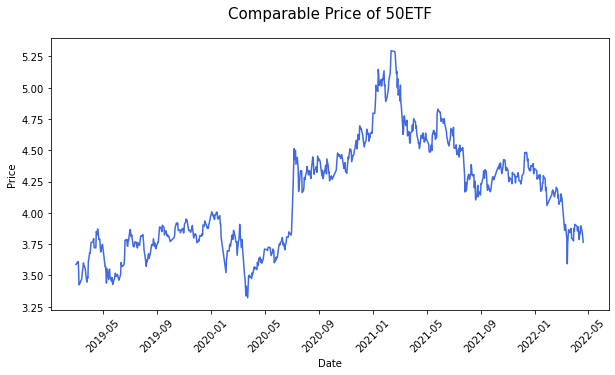

In [93]:
plt.figure(figsize=(10,5))
plt.plot(ETF_price_use['TradingDate'],ETF_price_use['ComparablePrice'],color='royalblue')
plt.xticks(rotation=45)
plt.title('Comparable Price of 50ETF',fontsize=15,pad=20)
plt.ylabel('Price')
plt.xlabel('Date')

2. 正态分布检验

In [94]:
norm=0.000156+0.01252*np.random.randn(len(time_series))

Text(0.5, 0, 'Value')

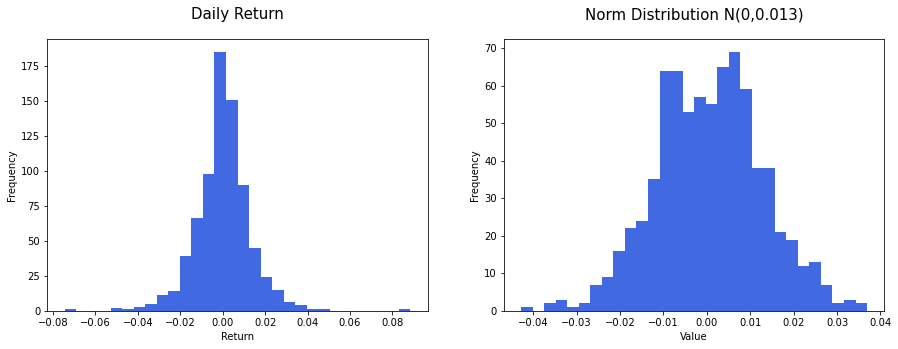

In [95]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(time_series,bins=30,color='royalblue')
plt.title('Daily Return',fontsize=15,pad=20)
plt.ylabel('Frequency')
plt.xlabel('Return')
plt.subplot(1,2,2)
plt.hist(norm,bins=30,color='royalblue')
plt.title('Norm Distribution N(0,0.013)',fontsize=15,pad=20)
plt.ylabel('Frequency')
plt.xlabel('Value')
#plt.plot(x,y1)

In [96]:
from scipy.stats import shapiro
data = time_series
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

stat=0.951, p=0.000
Probably not Gaussian


3. 自相关性检验

In [391]:
resi=list(time_series-np.mean(time_series))
resi2=list((time_series-np.mean(time_series))*(time_series-np.mean(time_series)))

In [392]:
time_series

0      0.024123
1      0.004640
2     -0.000710
3      0.002488
4     -0.016667
         ...   
814    0.015701
815    0.001031
816   -0.014756
817   -0.009404
818   -0.009845
Name: ReturnDaily, Length: 763, dtype: float64

In [98]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def ts_test(resi):
    dftest = adfuller(resi)
    Lj=acorr_ljungbox(resi, lags=5)

    acf = smt.stattools.acf(resi,nlags=3)
    pacf = smt.stattools.pacf(resi,nlags = 3)

    plot_acf(np.array(resi))
    plot_pacf(np.array(resi))

    result_ts=pd.concat([pd.DataFrame([dftest[0]]+list(Lj[0])),pd.DataFrame([dftest[1]]+list(Lj[1]))],axis=1)
    result_ts.columns=['t-value','p-value']
    result_ts.index=['ADF','Lj-1','Lj-2','Lj-3','Lj-4','Lj-5']
    result_ts=result_ts.round(3)
    
    return result_ts.T
    

ADF   Lj-1   Lj-2   Lj-3   Lj-4   Lj-5
t-value -27.925  0.092  0.107  0.828  2.707  4.162
p-value   0.000  0.762  0.948  0.843  0.608  0.526

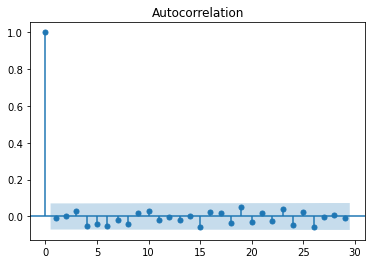

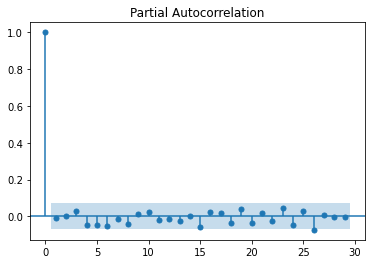

In [99]:
ts_test(resi)

ADF    Lj-1    Lj-2    Lj-3    Lj-4    Lj-5
t-value -23.781  16.612  18.341  18.996  21.214  21.245
p-value   0.000   0.000   0.000   0.000   0.000   0.001

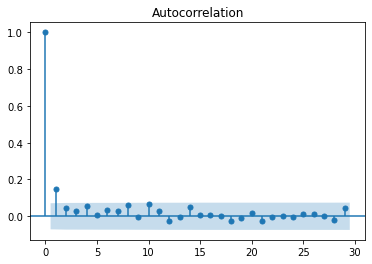

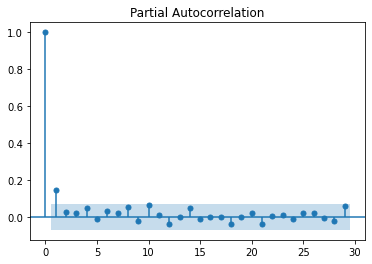

In [100]:
ts_test(resi2)

Text(0.5, 1.0, 'Price and Volatility of 50ETF')

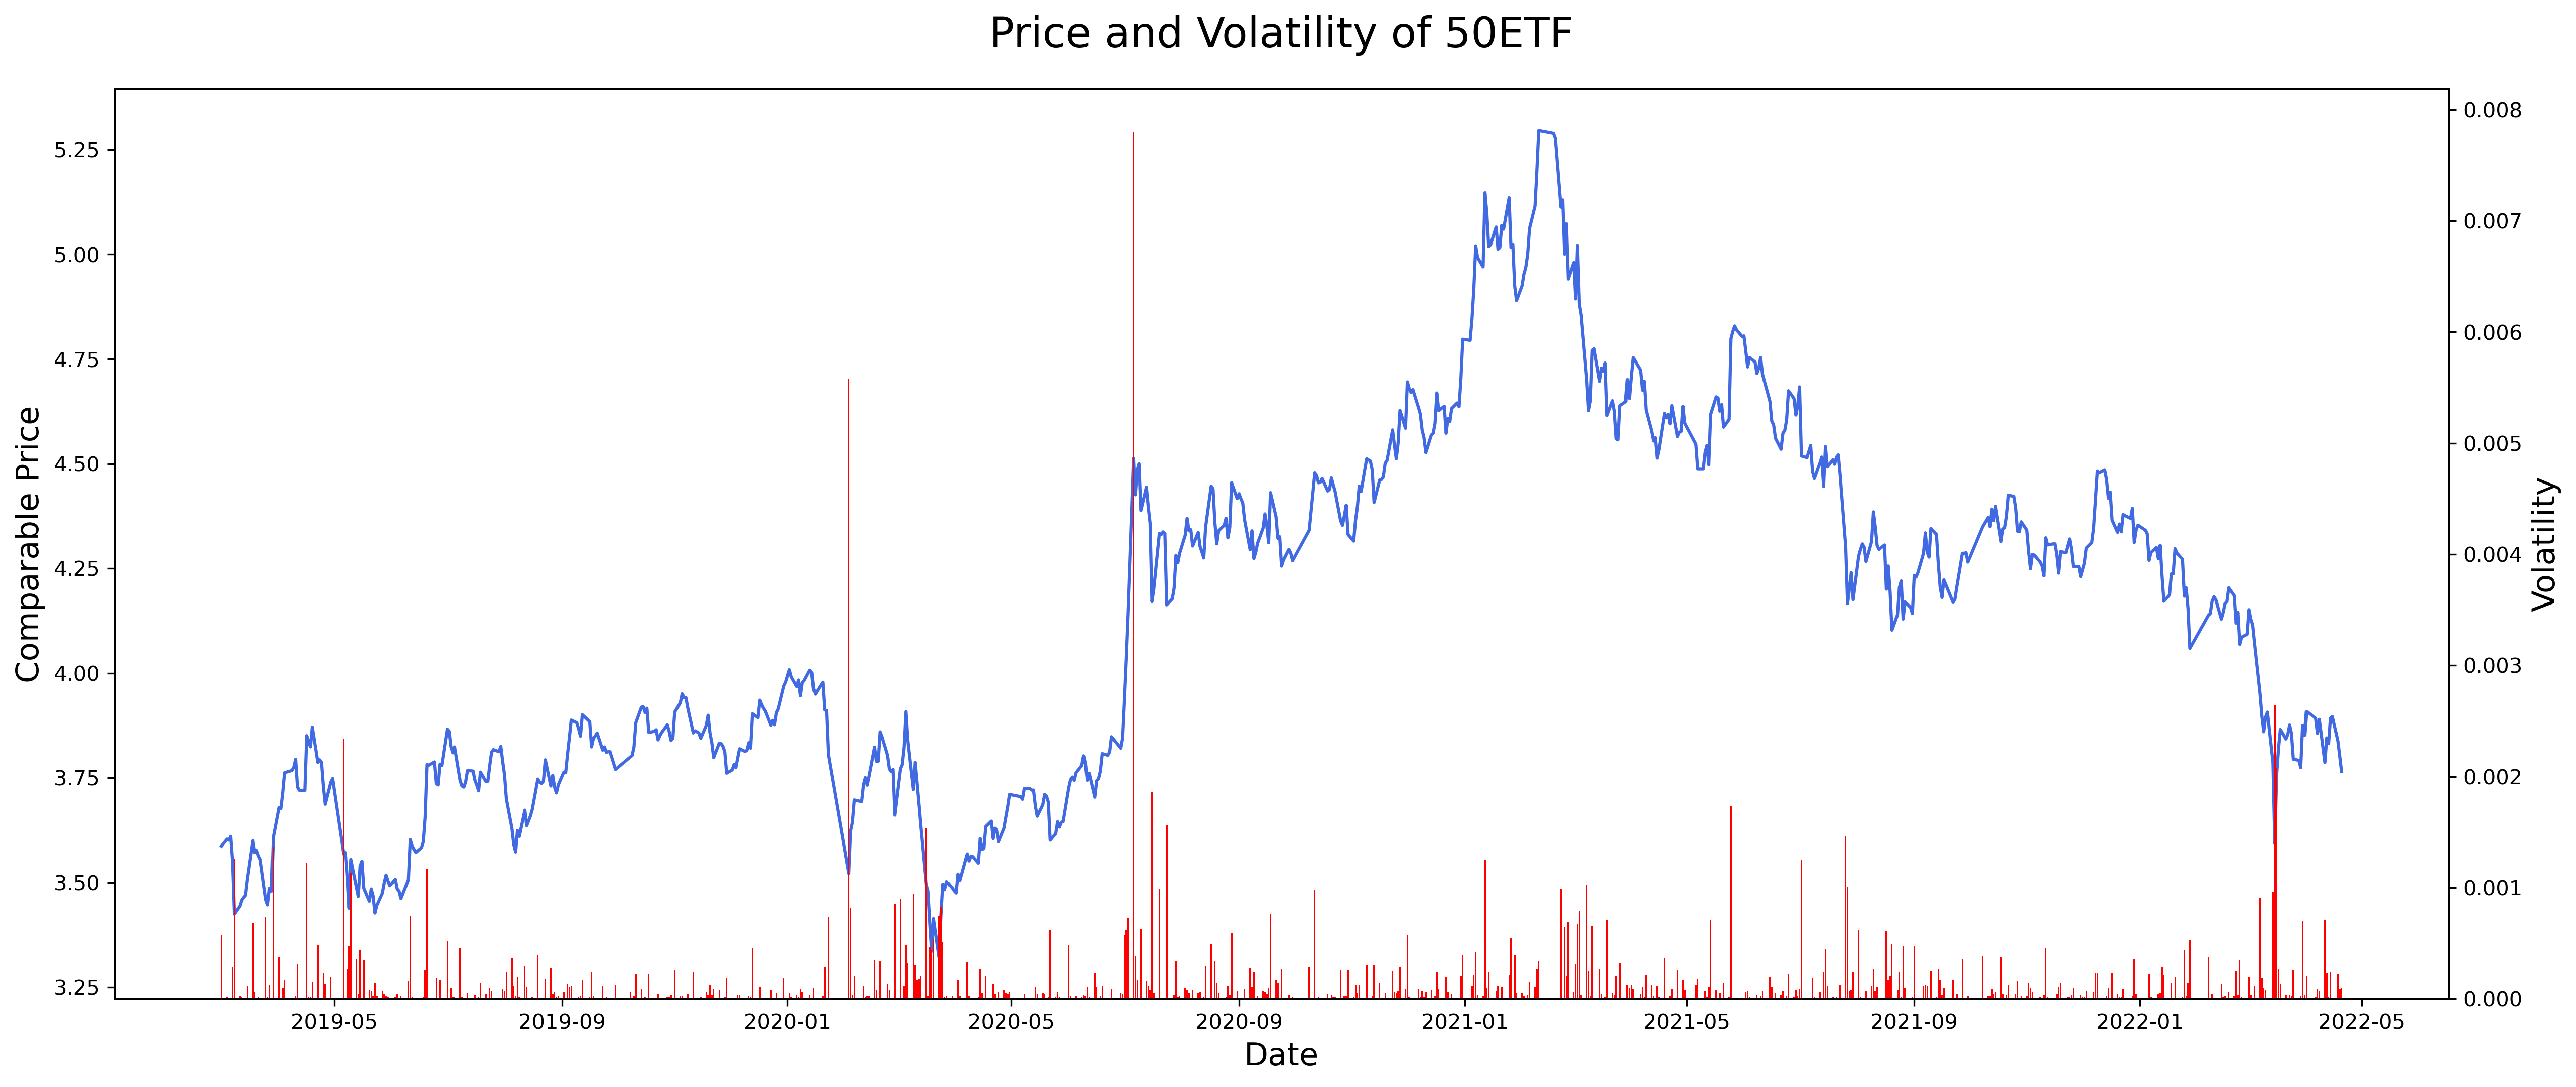

In [393]:
#pd.DataFrame(resi2,ETF_price_use['TradingDate']).plot(figsize=(8,5),title='Volatility',
#                                                     legend=False,color='royalblue')
figure = plt.figure(figsize=(20, 8), dpi=300)
ax1 = figure.add_subplot(111)
ax1.plot(ETF_price_use['TradingDate'],ETF_price_use['ComparablePrice'],color='royalblue')
ax2 = ax1.twinx()
ax2.bar(ETF_price_use['TradingDate'],resi2,color='red')
ax1.set_ylabel("Comparable Price",fontsize=15)
ax2.set_ylabel("Volatility",fontsize=15)
ax1.set_xlabel('Date',fontsize=15)
plt.title("Price and Volatility of 50ETF",fontsize=20,pad=20)

# 二. GARCH建模以及蒙特卡罗模拟

## 1. 波动率建模

In [102]:
from arch import arch_model
garch=arch_model(y=ETF_price_use['ReturnDaily'],vol='GARCH',p=1,o=0,q=1,dist='normal')
garchmodel=garch.fit()
garchmodel.summary()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 99083451.2846358
Iteration:      2,   Func. Count:     17,   Neg. LLF: -2271.477069090861
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2271.477069693804
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            ReturnDaily   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2271.48
Distribution:                  Normal   AIC:                          -4534.95
Method:            Maximum Likelihood   BIC:                          -4516.41
                                        No. Observations:                  763
Date:                Sat, Jul 02 2022   Df Residuals:                      762
Time:                        11:47:37   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.8483e-04  3.944e-04      0.722      0.470 [-4.882e-04,1.058e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.6526e-05  6.131e-12  2.696e+06      0.000 [1.653e-05,1.653e-05]
alpha[1]       0.1000  4.473e-02      2.236  2.537e-02   [1.234e-02,  0.188]
beta[1]        0.8000  3.234e-02     24.737 4.229e-135     [  0.737,  0.863]
============================================================================

Covariance estimator: robust
"""

In [103]:
garchmodel.params

mu          0.000285
omega       0.000017
alpha[1]    0.100000
beta[1]     0.800000
Name: params, dtype: float64

In [104]:
#长期波动率计算
Vl=garchmodel.params['omega']/(1-garchmodel.params['alpha[1]']-garchmodel.params['beta[1]'])
volatility_long=np.sqrt(Vl*252)
volatility_long

0.2040730810798392

In [105]:
#计算估计波动率，并与真实的进行比较
resi2=list((time_series-garchmodel.params['mu'])**2)

In [106]:
var=[resi2[0]]
for i in range(1,len(resi2)):
    var.append(garchmodel.params['omega']+garchmodel.params['alpha[1]']*resi2[i-1]+
              garchmodel.params['beta[1]']*var[i-1])

In [107]:
ETF_price_use['Volatility']=np.sqrt(var)
ETF_price_use['Variance']=var
ETF_price_use['RealVariance']=resi2

In [108]:
#可视化

Text(0.5, 1.0, 'Real and Model Volatility of 50ETF')

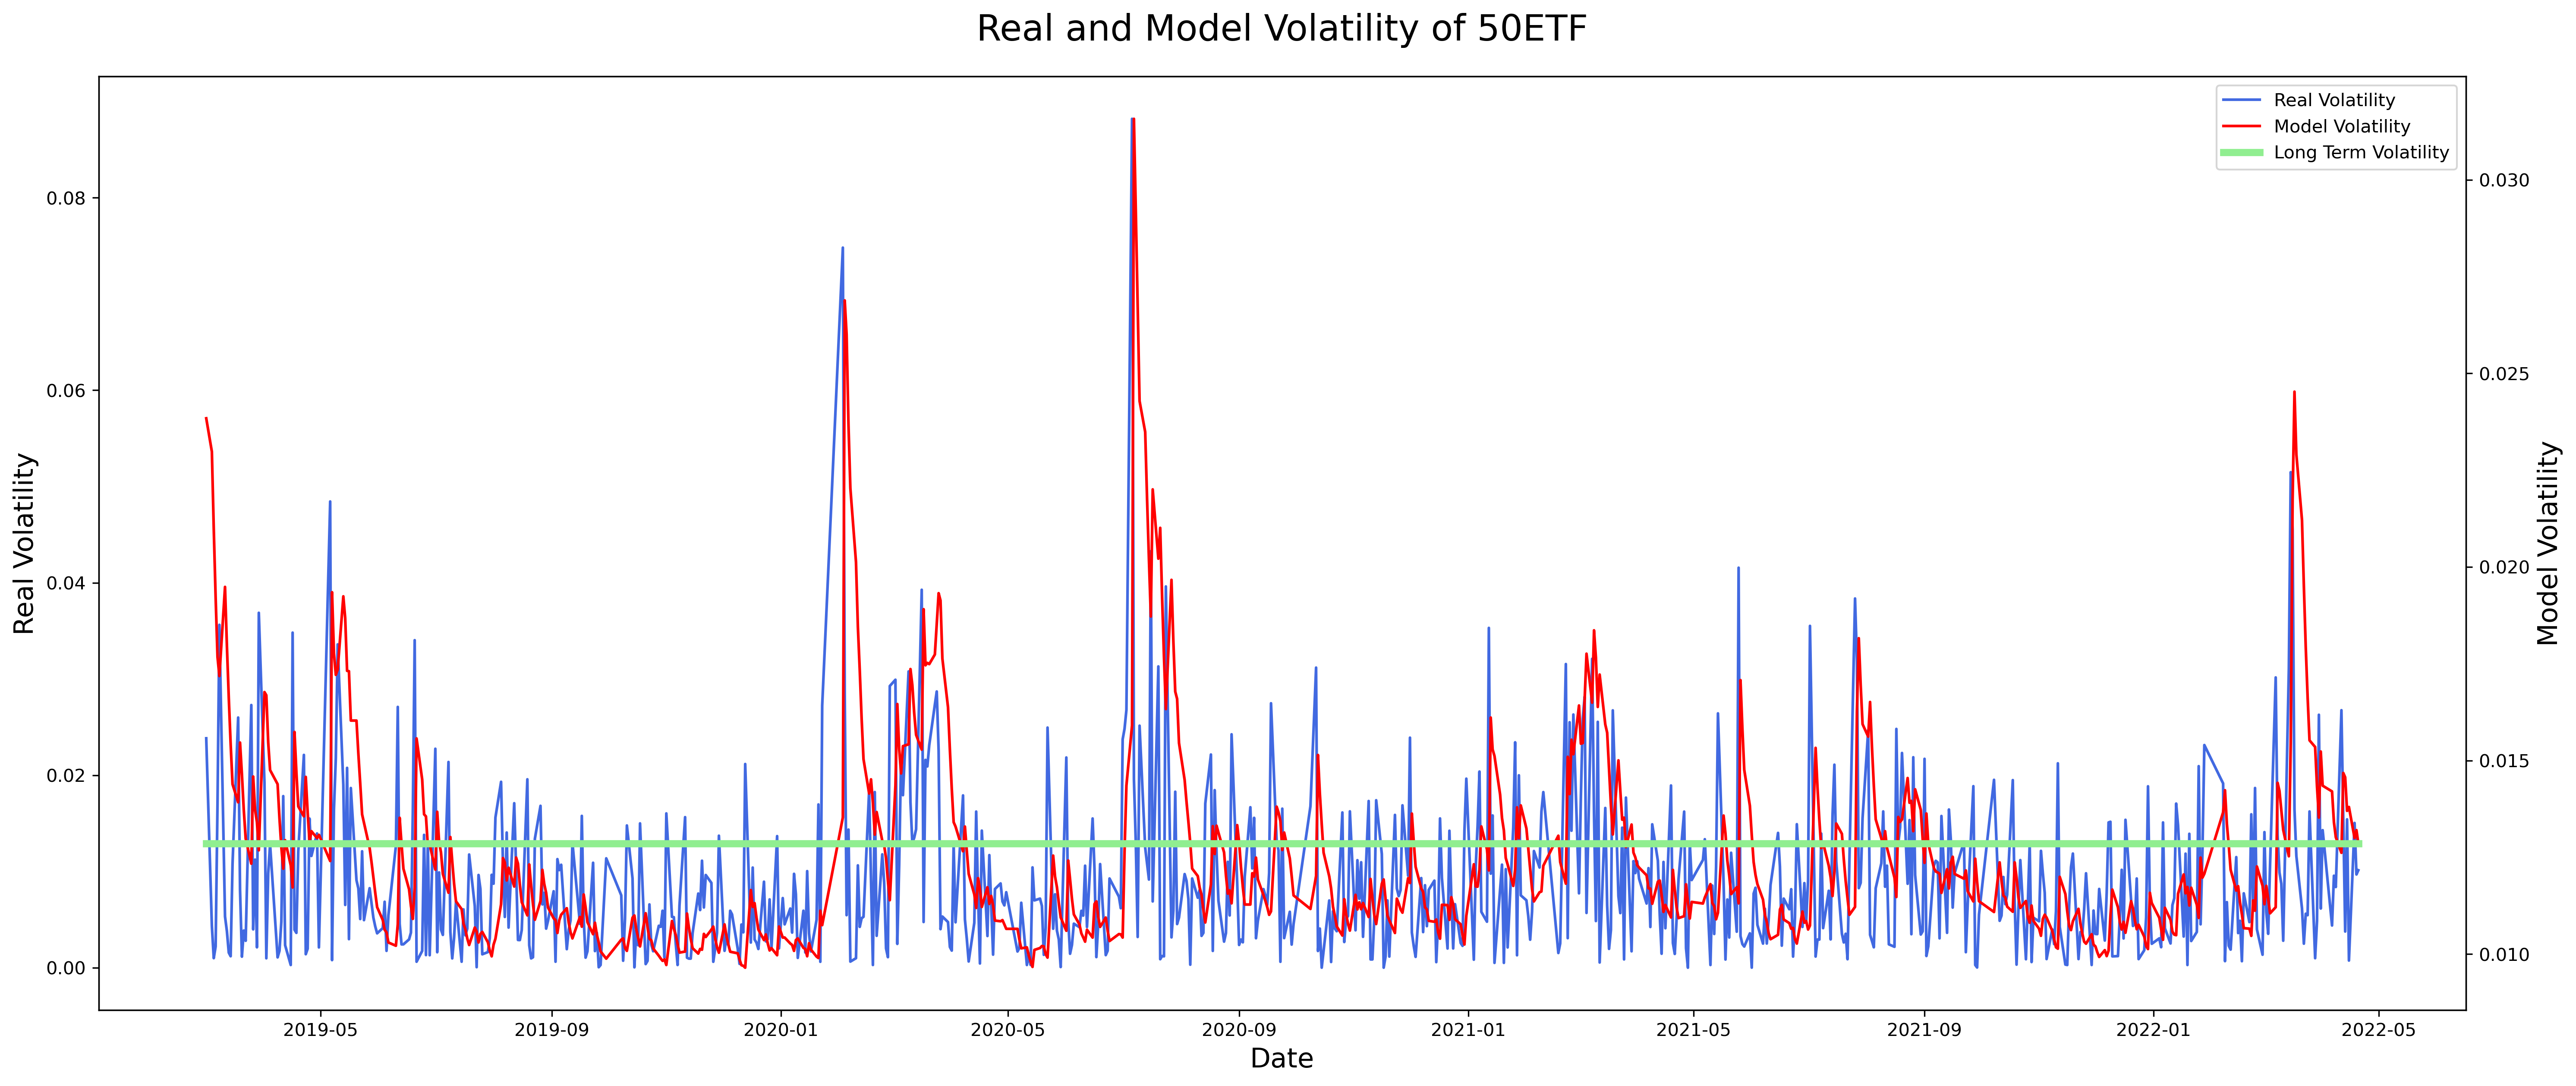

In [109]:
figure = plt.figure(figsize=(20, 8), dpi=300)
ax1 = figure.add_subplot(111)
a=plt.plot(ETF_price_use.iloc[:,0],np.sqrt(resi2),color='royalblue')
#plt.legend(['Real Volatility','11'])
ax2 = ax1.twinx()
b=ax2.plot(ETF_price_use.iloc[:,0],np.sqrt(var),color='red')
c=ax2.plot(ETF_price_use.iloc[:,0],np.ones(len(ETF_price_use.iloc[:,0]))*volatility_long/np.sqrt(252),linewidth=4,color='lightgreen')
ax1.set_ylabel("Real Volatility",fontsize=15)
ax2.set_ylabel("Model Volatility",fontsize=15)
ax1.set_xlabel('Date',fontsize=15)
plt.legend(a+b+c, ['Real Volatility','Model Volatility','Long Term Volatility'])
plt.tight_layout()
plt.title("Real and Model Volatility of 50ETF",fontsize=20,pad=20)
#plt.legend(['Real Volatility','Model Volatility'])

## 2. 波动率模型的检验

ADF   Lj-1   Lj-2   Lj-3   Lj-4   Lj-5
t-value -25.829  3.241  3.673  3.693  3.731  4.354
p-value   0.000  0.072  0.159  0.297  0.444  0.500

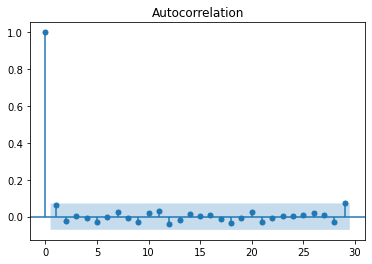

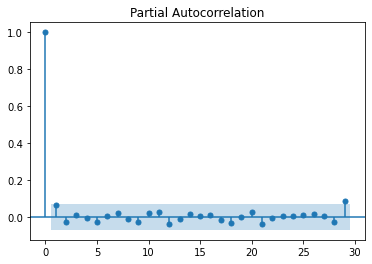

In [110]:
ETF_price_use['test']=ETF_price_use['RealVariance']/ETF_price_use['Variance']
ts_test(ETF_price_use['test'])

## 3. 与期权隐含波动率比较

In [111]:
ETF_opt_use=ETF_opt[['TradingDate','ImpliedVolatility']]
ETF_opt_use['TradingDate']=pd.to_datetime(ETF_opt_use['TradingDate'])

In [112]:
vol_compare=pd.merge(ETF_price_use,ETF_opt_use,on='TradingDate',how='left').dropna().iloc[:,[0,3,5,7]]
#年化
vol_compare['Volatility_year']=vol_compare['Volatility']*np.sqrt(252)

In [113]:
vol_compare.head(5)

TradingDate  Volatility  RealVariance  ImpliedVolatility  Volatility_year
646  2021-10-28    0.011253  3.467246e-07             0.1829         0.178638
647  2021-10-29    0.010857  2.696898e-05             0.1778         0.172345
648  2021-11-01    0.010654  2.327902e-05             0.1888         0.169134
649  2021-11-02    0.010472  1.474484e-04             0.1919         0.166242
650  2021-11-03    0.010909  9.648805e-05             0.1987         0.173174

Text(0.5, 1.0, 'Annualized Volatility of 50ETF')

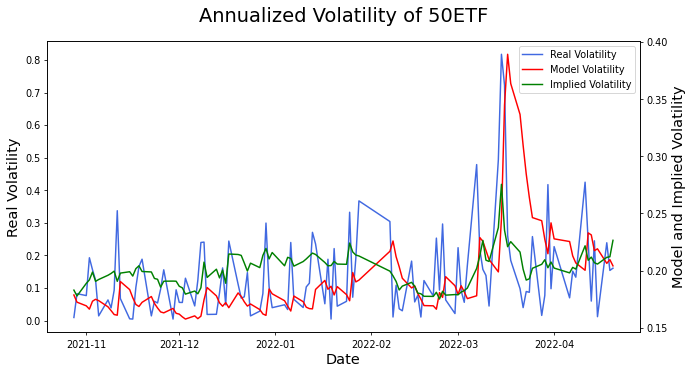

In [114]:
#可视化
figure = plt.figure(figsize=(10,5), dpi=70)
ax1 = figure.add_subplot(111)
a=plt.plot(vol_compare.iloc[:,0],np.sqrt(vol_compare['RealVariance'])*np.sqrt(252),color='royalblue')
#plt.legend(['Real Volatility','11'])
ax2 = ax1.twinx()
b=ax2.plot(vol_compare.iloc[:,0],vol_compare['Volatility_year'],color='red')
c=ax2.plot(vol_compare.iloc[:,0],vol_compare['ImpliedVolatility'],color='green')
ax1.set_ylabel("Real Volatility",fontsize=15)
ax2.set_ylabel("Model and Implied Volatility",fontsize=15)
ax1.set_xlabel('Date',fontsize=15)
plt.legend(a+b+c, ['Real Volatility','Model Volatility','Implied Volatility'])
plt.tight_layout()
plt.title("Annualized Volatility of 50ETF",fontsize=20,pad=20)
#plt.legend(['Real Volatility','Model Volatility'])

<AxesSubplot:title={'center':'Correlation of Annualized Volatility'}>

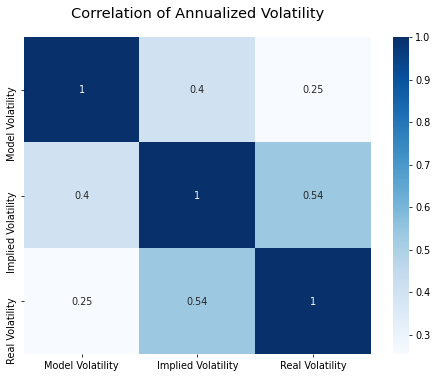

In [115]:
#三种波动率之间的相关性
Vol_df=pd.DataFrame([list(vol_compare['Volatility_year']),list(vol_compare['ImpliedVolatility']),list(np.sqrt(252*vol_compare['RealVariance']))]).T
Vol_df.columns=['Model Volatility','Implied Volatility','Real Volatility']
import seaborn as sns
plt.figure(figsize=(8,6),dpi=70)
plt.title('Correlation of Annualized Volatility',fontsize=15,pad=20)
sns.heatmap(Vol_df.corr(),annot=True,cmap="Blues")

## 4. 蒙特卡罗模拟

（1）波动率预测

In [116]:
Var_pred=garchmodel.params['omega']+garchmodel.params['alpha[1]']*resi2[-1]+garchmodel.params['beta[1]']*var[-1]


In [117]:
Var_pred_10=[list(vol_compare['Volatility'])[-1]**2,Var_pred]
for i in range(0,34):
    Var_pred_10.append(garchmodel.params['omega']+garchmodel.params['alpha[1]']*Var_pred_10[i]+garchmodel.params['beta[1]']*Var_pred_10[i])


In [118]:
Vol_pred_year=np.sqrt(np.array(Var_pred_10)*252)

In [119]:
opt_price=ETF_opt[['TradingDate','TheoreticalPrice']].iloc[-36:,:]
opt_price['Vol_pred_year']=Vol_pred_year
opt_price['TradingDate']=pd.to_datetime(opt_price['TradingDate'])

In [120]:
len(opt_price)

36

Text(0.5, 1.0, 'Prediction of Annulized Volatility')

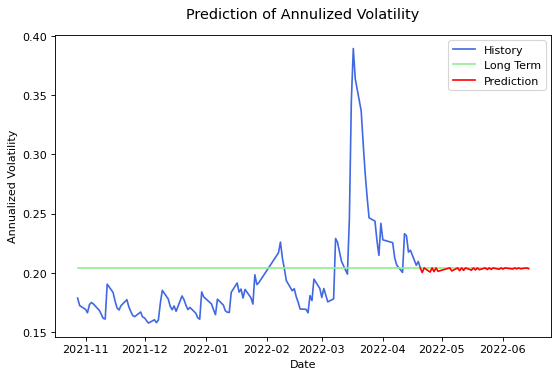

In [121]:
K=list(vol_compare['Volatility_year'])
P=list(Vol_pred_year)
plt.figure(figsize=(8,5),dpi=80)
plt.plot(list(vol_compare['TradingDate']),K,color='royalblue')
l=len(vol_compare['TradingDate'])+len(opt_price['TradingDate'])-1
plt.plot(list(vol_compare['TradingDate'])[:-1]+list(opt_price['TradingDate']),np.ones(l)*0.2041,color='lightgreen')
plt.plot(list(opt_price['TradingDate']),P,color='red')
plt.legend(['History','Long Term','Prediction'])
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.title('Prediction of Annulized Volatility',fontsize=13,pad=15)

（2）标的资产价格预测

In [136]:
deltat=1/252
S0=ETF_price_use.iloc[-1,2]
K=3.159
r=0.015
Timesteps=10
sigma=Vol_pred_year
miu=garchmodel.params['mu']*252
N=100

In [137]:
miu

0.07177798574246676

In [138]:
ETF_price['TradingDate']=pd.to_datetime(ETF_price['TradingDate'])
ETF_price.iloc[-8:]

TradingDate  Symbol  OpenPrice  ClosePrice  ReturnDaily  \
818  2022-04-20  510050      2.846       2.816    -0.009845   
819  2022-04-21  510050      2.804       2.780    -0.012784   
820  2022-04-22  510050      2.758       2.795     0.005396   
821  2022-04-25  510050      2.740       2.662    -0.047585   
822  2022-04-26  510050      2.660       2.664     0.000751   
823  2022-04-27  510050      2.662       2.714     0.018769   
824  2022-04-28  510050      2.706       2.749     0.012896   
825  2022-04-29  510050      2.761       2.793     0.016006   

     SimpleReturnDaily  ComparablePrice  SimpleComparablePrice  
818          -0.009845         3.765118               2.815996  
819          -0.012784         3.716985               2.779996  
820           0.005396         3.737042               2.794997  
821          -0.047585         3.559215               2.661997  
822           0.000751         3.561888               2.663996  
823           0.018769         3.628741               2.713997  
824           0.012896         3.675537               2.748997  
825           0.016006         3.734368               2.792997

In [139]:
S_total=[]
for i in range(0,N):
    S=[S0]
    for j in range(0,Timesteps):
        rand=sum(np.random.rand(12))-6
        #print(np.exp((miu)*deltat+sigma[j]*(rand)*np.sqrt(deltat)))
        S1=S[j]*np.exp((miu-1/2*sigma[j]**2)*deltat+sigma[j]*(rand)*np.sqrt(deltat))
        #-1/2*sigma[j]**2
        S.append(S1)
    S_total.append(S)
    S0=S[0]

In [140]:
S_mean=pd.DataFrame(S_total).quantile(1)[0:8]
S_mean

0    3.765118
1    3.905394
2    3.983947
3    4.002830
4    4.055147
5    4.119095
6    4.121007
7    4.141317
Name: 1, dtype: float64

Text(0, 0.5, 'Price')

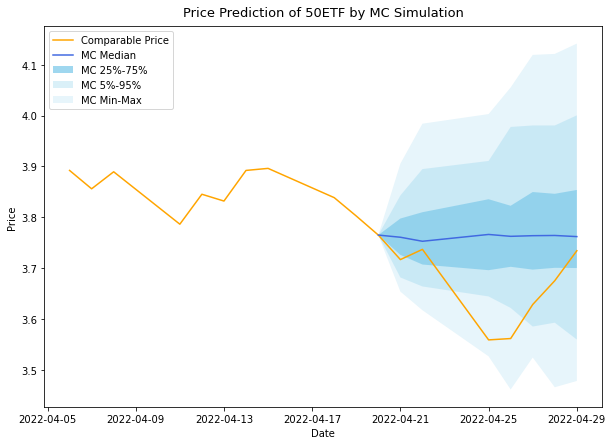

In [141]:
S_50=pd.DataFrame(S_total).quantile(0.5)[0:8]
S_25=pd.DataFrame(S_total).quantile(0.25)[0:8]
S_75=pd.DataFrame(S_total).quantile(0.75)[0:8]
S_5=pd.DataFrame(S_total).quantile(0.05)[0:8]
S_95=pd.DataFrame(S_total).quantile(0.95)[0:8]
S_min=pd.DataFrame(S_total).min()[0:8]
S_max=pd.DataFrame(S_total).max()[0:8]

plt.figure(figsize=(10,7))
plt.plot(list(ETF_price['TradingDate'])[807:],list(ETF_price['ComparablePrice'])[807:],color='orange')
plt.plot(list(ETF_price['TradingDate'])[-8:],S_50,color='royalblue')
plt.fill_between(list(ETF_price['TradingDate'])[-8:],S_75,S_25,facecolor = 'skyblue', alpha = 0.8)
plt.fill_between(list(ETF_price['TradingDate'])[-8:],S_95,S_5,facecolor = 'skyblue', alpha = 0.3)
plt.fill_between(list(ETF_price['TradingDate'])[-8:],S_max,S_min,facecolor = 'skyblue', alpha = 0.2)
plt.legend(['Comparable Price','MC Median','MC 25%-75%','MC 5%-95%','MC Min-Max',3],loc='upper left')
plt.title('Price Prediction of 50ETF by MC Simulation',fontsize=13,pad=10)
plt.xlabel('Date')
plt.ylabel('Price')

In [142]:
Price_df=pd.DataFrame(S_total)

In [143]:
Price_df.head(5)

0         1         2         3         4         5         6   \
0  3.765118  3.835848  3.853739  3.866782  3.932946  3.915924  3.857926   
1  3.765118  3.737777  3.707622  3.670991  3.729412  3.697983  3.722904   
2  3.765118  3.862776  3.852755  3.906299  3.886343  3.905347  3.931935   
3  3.765118  3.750568  3.739132  3.858321  3.819566  3.857987  3.847683   
4  3.765118  3.761742  3.779379  3.773717  3.771977  3.737476  3.736437   

         7         8         9         10  
0  3.866533  3.867450  3.973070  4.019293  
1  3.653187  3.626523  3.632455  3.580740  
2  3.974645  3.830146  3.851514  3.925025  
3  3.958808  3.994209  3.931403  3.973231  
4  3.748488  3.774158  3.796335  3.871250

（3）期权价格预测

In [144]:
ETF_opt['ExerciseDate'][0]
T=(30-8+31+22)/365

In [145]:
def call_BS(S0,miu,T,K,rf,sigma):
    d1=(np.log(S0/K)+(rf-miu+sigma**2/2)*T)/(sigma*np.sqrt(T))
    import scipy.stats as stats
    d2=d1-sigma*np.sqrt(T)
    P=S0*np.exp(-miu*T)*stats.norm.cdf(d1,0,1)-K*np.exp(-rf*T)*stats.norm.cdf(d2,0,1)
    return P

In [146]:
O_total=[]
for i in range(0,N):
    O_one=[]
    for j in range(0,Timesteps+1):
        P=call_BS(Price_df.iloc[i,j],miu,T-j/252,K,r,sigma[j])
        O_one.append(P)
    O_total.append(O_one)

Text(0, 0.5, 'Price')

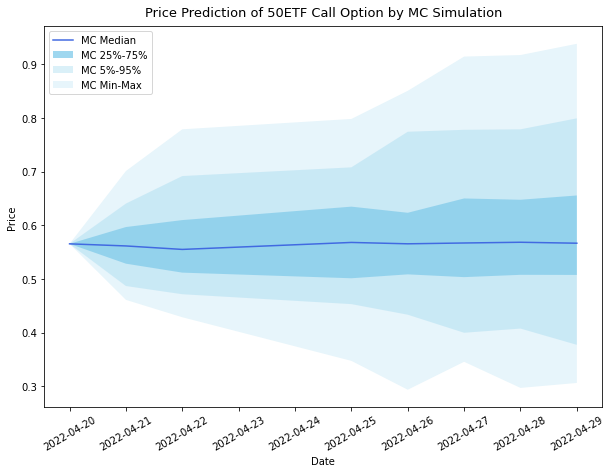

In [147]:
O_50=pd.DataFrame(O_total).quantile(0.5)[0:8]
O_25=pd.DataFrame(O_total).quantile(0.25)[0:8]
O_75=pd.DataFrame(O_total).quantile(0.75)[0:8]
O_5=pd.DataFrame(O_total).quantile(0.05)[0:8]
O_95=pd.DataFrame(O_total).quantile(0.95)[0:8]
O_min=pd.DataFrame(O_total).min()[0:8]
O_max=pd.DataFrame(O_total).max()[0:8]

plt.figure(figsize=(10,7))
plt.plot(list(ETF_price['TradingDate'])[-8:],O_50,color='royalblue')
plt.fill_between(list(ETF_price['TradingDate'])[-8:],O_75,O_25,facecolor = 'skyblue', alpha = 0.8)
plt.fill_between(list(ETF_price['TradingDate'])[-8:],O_95,O_5,facecolor = 'skyblue', alpha = 0.3)
plt.fill_between(list(ETF_price['TradingDate'])[-8:],O_max,O_min,facecolor = 'skyblue', alpha = 0.2)
plt.legend(['MC Median','MC 25%-75%','MC 5%-95%','MC Min-Max',3],loc='upper left')
plt.title('Price Prediction of 50ETF Call Option by MC Simulation',fontsize=13,pad=10)
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('Price')


In [148]:
opt_price=ETF_opt[['TradingDate','TheoreticalPrice']].iloc[-44:-33,:]
opt_price['MC_Price']=list(pd.DataFrame(O_total).mean())
opt_price['MC_Price_std']=list(pd.DataFrame(O_total).std())
opt_price

TradingDate  TheoreticalPrice  MC_Price  MC_Price_std
108  2022-04-08            0.0248  0.565568  1.115816e-15
109  2022-04-11            0.0130  0.563348  5.141675e-02
110  2022-04-12            0.0189  0.567229  6.874947e-02
111  2022-04-13            0.0169  0.570880  8.952312e-02
112  2022-04-14            0.0237  0.574442  1.003472e-01
113  2022-04-15            0.0236  0.576638  1.131267e-01
114  2022-04-18            0.0156  0.577914  1.198833e-01
115  2022-04-19            0.0119  0.579785  1.257603e-01
116  2022-04-20            0.0087  0.579561  1.375786e-01
117  2022-04-21            0.0059  0.581511  1.488619e-01
118  2022-04-22            0.0067  0.583560  1.649591e-01

（4）损失分布计算

In [149]:
O_df=pd.DataFrame(O_total)
Loss_df=[]
for i in range(1,len(O_df.columns)):
    Loss=-(O_df[i]-O_df[0])
    quantiles=[Loss.quantile(0),Loss.quantile(0.01),Loss.quantile(0.05),Loss.quantile(0.25),Loss.quantile(0.5),Loss.quantile(0.75),Loss.quantile(0.95),Loss.quantile(0.99),Loss.quantile(1)]
    Loss_df.append(quantiles)
Loss_df=pd.DataFrame(Loss_df).iloc[:8,:]

In [150]:
Loss_df

0         1         2         3         4         5         6  \
0 -0.135670 -0.120256 -0.075005 -0.031309  0.003927  0.036974  0.078609   
1 -0.213418 -0.154371 -0.126301 -0.044266  0.010400  0.053659  0.093890   
2 -0.232709 -0.229386 -0.142537 -0.069320 -0.002605  0.064155  0.112310   
3 -0.285082 -0.247904 -0.208859 -0.057898 -0.000059  0.056869  0.132043   
4 -0.348933 -0.317954 -0.212475 -0.084581 -0.001580  0.062040  0.165690   
5 -0.351795 -0.312242 -0.213389 -0.082136 -0.002943  0.057736  0.157876   
6 -0.372761 -0.353349 -0.233823 -0.090137 -0.001173  0.057967  0.188187   
7 -0.388181 -0.360822 -0.245897 -0.088097 -0.004698  0.078304  0.186034   

          7         8  
0  0.104015  0.104415  
1  0.130802  0.136763  
2  0.148523  0.218054  
3  0.167300  0.271827  
4  0.214279  0.219783  
5  0.197552  0.268442  
6  0.209340  0.259218  
7  0.263918  0.295606

Text(0, 0.5, 'Loss')

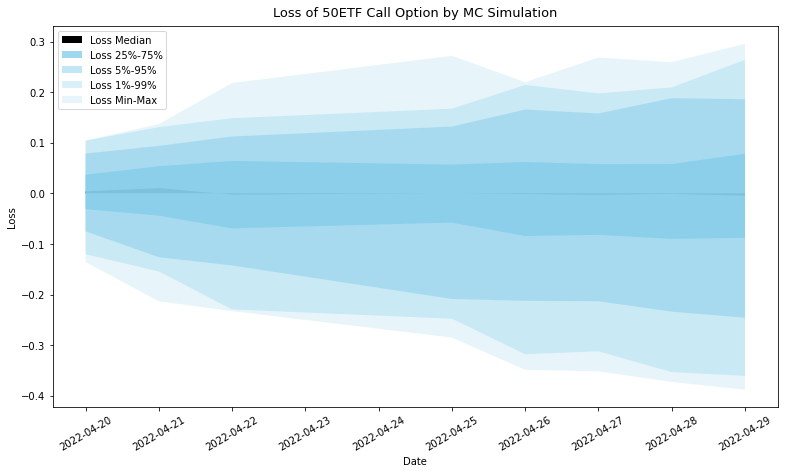

In [151]:

Loss_df.columns
plt.figure(figsize=(13,7))
plt.fill_between(list(ETF_price['TradingDate'])[-8:],Loss_df[4],facecolor = 'black')
plt.fill_between(list(ETF_price['TradingDate'])[-8:],Loss_df[5],Loss_df[3],facecolor = 'skyblue', alpha = 0.8)
plt.fill_between(list(ETF_price['TradingDate'])[-8:],Loss_df[6],Loss_df[2],facecolor = 'skyblue', alpha = 0.5)
plt.fill_between(list(ETF_price['TradingDate'])[-8:],Loss_df[7],Loss_df[1],facecolor = 'skyblue', alpha = 0.3)
plt.fill_between(list(ETF_price['TradingDate'])[-8:],Loss_df[8],Loss_df[0],facecolor = 'skyblue', alpha = 0.2)
plt.legend(['Loss Median','Loss 25%-75%','Loss 5%-95%','Loss 1%-99%','Loss Min-Max',3],loc='upper left')
plt.title('Loss of 50ETF Call Option by MC Simulation',fontsize=13,pad=10)
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('Loss')


In [152]:
Loss_df.index=list(ETF_price['TradingDate'])[-8:]
Loss_df.round(3)

0      1      2      3      4      5      6      7      8
2022-04-20 -0.136 -0.120 -0.075 -0.031  0.004  0.037  0.079  0.104  0.104
2022-04-21 -0.213 -0.154 -0.126 -0.044  0.010  0.054  0.094  0.131  0.137
2022-04-22 -0.233 -0.229 -0.143 -0.069 -0.003  0.064  0.112  0.149  0.218
2022-04-25 -0.285 -0.248 -0.209 -0.058 -0.000  0.057  0.132  0.167  0.272
2022-04-26 -0.349 -0.318 -0.212 -0.085 -0.002  0.062  0.166  0.214  0.220
2022-04-27 -0.352 -0.312 -0.213 -0.082 -0.003  0.058  0.158  0.198  0.268
2022-04-28 -0.373 -0.353 -0.234 -0.090 -0.001  0.058  0.188  0.209  0.259
2022-04-29 -0.388 -0.361 -0.246 -0.088 -0.005  0.078  0.186  0.264  0.296

In [153]:
def VaR_ES(Loss_df,Alpha,draw=True):
    plt.figure(figsize=(7,5),dpi=90)
    plt.hist(Loss_df['Loss'][Loss_df['Loss']<=Loss_df['Loss'].quantile(0.95)],bins=50,color='skyblue',alpha=0.7)
    plt.hist(Loss_df['Loss'][(Loss_df['Loss']>=Loss_df['Loss'].quantile(0.95))& (Loss_df['Loss']<=Loss_df['Loss'].quantile(0.99))],bins=10,color='royalblue')
    plt.hist(Loss_df['Loss'][Loss_df['Loss']>=Loss_df['Loss'].quantile(0.99)],bins=25,color='red')
    plt.title('Loss Distribution',fontsize=13,pad=15)
    plt.legend(['Loss <95% percentile','Loss 95%~99% percentile','Loss >=99% percentile'])
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    if draw:
        plt.show()
    
    Loss_sorted=Loss_df.sort_values(by=['Loss'],ascending=False)
    Loss_sorted['CumWeight']=Loss_sorted['Weight'].cumsum()
    Loss_over=Loss_sorted[Loss_sorted['CumWeight']<=1-Alpha]
    VaR=list(Loss_over['Loss'])[-1]
    ES=np.dot(Loss_over['Loss'],Loss_over['Weight'])/sum(Loss_over['Weight'])
    print('\t\t \tVaR={}, ES={}'.format(round(VaR,3),round(ES,3)))
    return [VaR,ES],Loss_sorted

# 三. 历史模拟法以及运用

## 1. 数据预处理

In [154]:
Comp_price_use=Comp_price[['Trddt','Dretwd','Adjprcwd']]
Comp_price_use['Trddt']=pd.to_datetime(Comp_price_use['Trddt'])

In [155]:
ETF_price_use=ETF_price_use[['TradingDate','ReturnDaily','ComparablePrice']]
ETF_price_use['TradingDate']=pd.to_datetime(ETF_price_use['TradingDate'])

In [156]:
table=pd.merge(ETF_price_use,Comp_price_use,left_on='TradingDate',right_on='Trddt',how='right')

In [157]:
table_split=table.iloc[0:501,:]

In [396]:
#时间加权
table_split

TradingDate  ReturnDaily  ComparablePrice      Trddt    Dretwd   Adjprcwd  \
0    2019-03-01     0.024123         3.587011 2019-03-01 -0.006386  24.930976   
1    2019-03-04     0.004640         3.603654 2019-03-04  0.000000  24.930976   
2    2019-03-05    -0.000710         3.601096 2019-03-05  0.019280  25.411650   
3    2019-03-06     0.002488         3.610055 2019-03-06  0.018916  25.892324   
4    2019-03-07    -0.016667         3.549886 2019-03-07  0.007426  26.084594   
..          ...          ...              ...        ...       ...        ...   
496  2021-03-16     0.006745         4.728381 2021-03-16 -0.015568  35.452122   
497  2021-03-17    -0.001675         4.720461 2021-03-17  0.013023  35.913824   
498  2021-03-18     0.004195         4.740263 2021-03-18 -0.007346  35.649994   
499  2021-03-19    -0.026455         4.614859 2021-03-19 -0.016651  35.056377   
500  2021-03-22     0.007723         4.650500 2021-03-22  0.013170  35.518079   

      ETF_vol  comp_vol    ETF_PF    comp_PF       Loss  
0    0.013293  0.028647  4.790895  35.293392  -1.525782  
1    0.014178  0.027818  4.675819  35.518079   7.629983  
2    0.013793  0.026971  4.646518  36.238588   0.745187  
3    0.013374  0.026572  4.664892  36.235589  -1.173586  
4    0.012981  0.026176  4.551165  35.804020  16.956472  
..        ...       ...       ...        ...        ...  
496  0.017214  0.031293  4.680814  35.016645  14.064154  
497  0.016772  0.030578  4.642773  35.947343   5.191343  
498  0.016266  0.029818  4.670453  35.269765  11.652639  
499  0.015804  0.028965  4.520990  34.938668  32.199434  
500  0.016636  0.028377  4.686416  35.985852   0.000000  

[501 rows x 11 columns]

## 2. 描述性统计

Text(0.5, 0, 'Date')

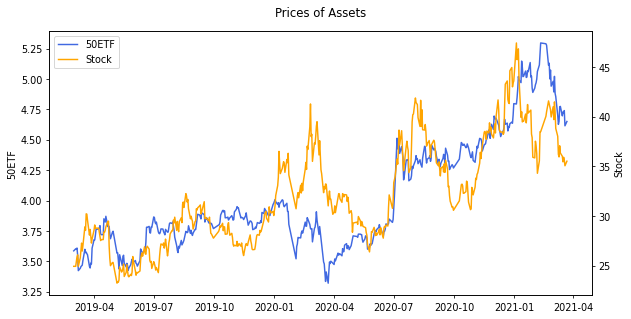

In [159]:
figure = plt.figure(figsize=(10,5), dpi=70)
ax1 = figure.add_subplot(111)
a=ax1.plot(table_split['TradingDate'],table_split['ComparablePrice'],color='royalblue')
ax1.set_ylabel("50ETF")
ax2 = ax1.twinx()
b=ax2.plot(table_split['TradingDate'],table_split['Adjprcwd'],color='orange')
ax2.set_ylabel("Stock")
plt.legend(a+b,['50ETF','Stock'],loc='upper left')
plt.title('Prices of Assets',fontsize=12,pad=15)
ax2.set_xlabel('Date')


## 3. 对观察值赋权

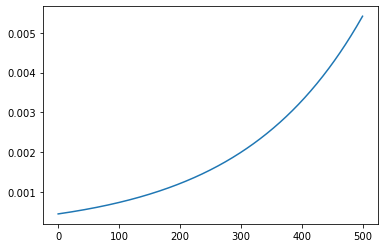

In [160]:
Lambda=0.995
time_weight=pow(Lambda,500-table_split.index[:-1])*(1-Lambda)/(1-pow(Lambda,500))
plt.plot(time_weight)

In [161]:
PF_ETF=list(table_split['ComparablePrice'])[-1]*(1+table_split['ReturnDaily'])
PF_Comp=list(table_split['Adjprcwd'])[-1]*(1+table_split['Dretwd'])

ETF_Value=500*PF_ETF/list(table_split['ComparablePrice'])[-1]
Comp_Value=500*PF_Comp/list(table_split['Adjprcwd'])[-1]
Tol_Value=ETF_Value+Comp_Value
Loss=1000-Tol_Value

In [162]:
table_tw=pd.DataFrame(table_split['TradingDate'])
table_tw['Loss']=Loss
table_tw['Weight']=list(time_weight)+[np.nan]

In [163]:
table_tw.head(5)

TradingDate     Loss    Weight
0  2019-03-01  -8.8685  0.000444
1  2019-03-04  -2.3200  0.000446
2  2019-03-05  -9.2850  0.000449
3  2019-03-06 -10.7020  0.000451
4  2019-03-07   4.6205  0.000453

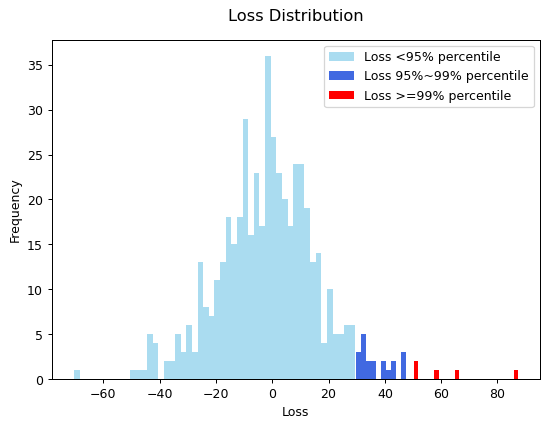

		 	VaR=29.371, ES=39.236


In [164]:
a,b=VaR_ES(table_tw.dropna().iloc[:,1:],Alpha=0.95)

## 4. 波动率估计赋权

In [165]:
table_split
Lambda=0.94
var_ETF=[np.std(table_split['ReturnDaily'])**2]
var_comp=[np.std(table_split['Dretwd'])**2]
for i in range(1,len(table_split)):
    var_ETF.append(Lambda*var_ETF[i-1]+(1-Lambda)*table_split['ReturnDaily'][i-1]**2)
    var_comp.append(Lambda*var_comp[i-1]+(1-Lambda)*table_split['Dretwd'][i-1]**2)

In [166]:
table_vol=table_split

In [167]:
table_vol['ETF_vol']=np.sqrt(np.array(var_ETF))
table_vol['comp_vol']=np.sqrt(np.array(var_comp))

In [168]:
table_vol.head(5)

TradingDate  ReturnDaily  ComparablePrice      Trddt    Dretwd   Adjprcwd  \
0  2019-03-01     0.024123         3.587011 2019-03-01 -0.006386  24.930976   
1  2019-03-04     0.004640         3.603654 2019-03-04  0.000000  24.930976   
2  2019-03-05    -0.000710         3.601096 2019-03-05  0.019280  25.411650   
3  2019-03-06     0.002488         3.610055 2019-03-06  0.018916  25.892324   
4  2019-03-07    -0.016667         3.549886 2019-03-07  0.007426  26.084594   

    ETF_vol  comp_vol  
0  0.013293  0.028647  
1  0.014178  0.027818  
2  0.013793  0.026971  
3  0.013374  0.026572  
4  0.012981  0.026176

Text(0.5, 1.0, 'Price and Volatility of Stock')

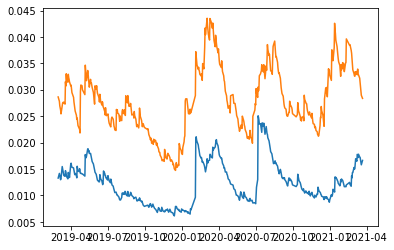

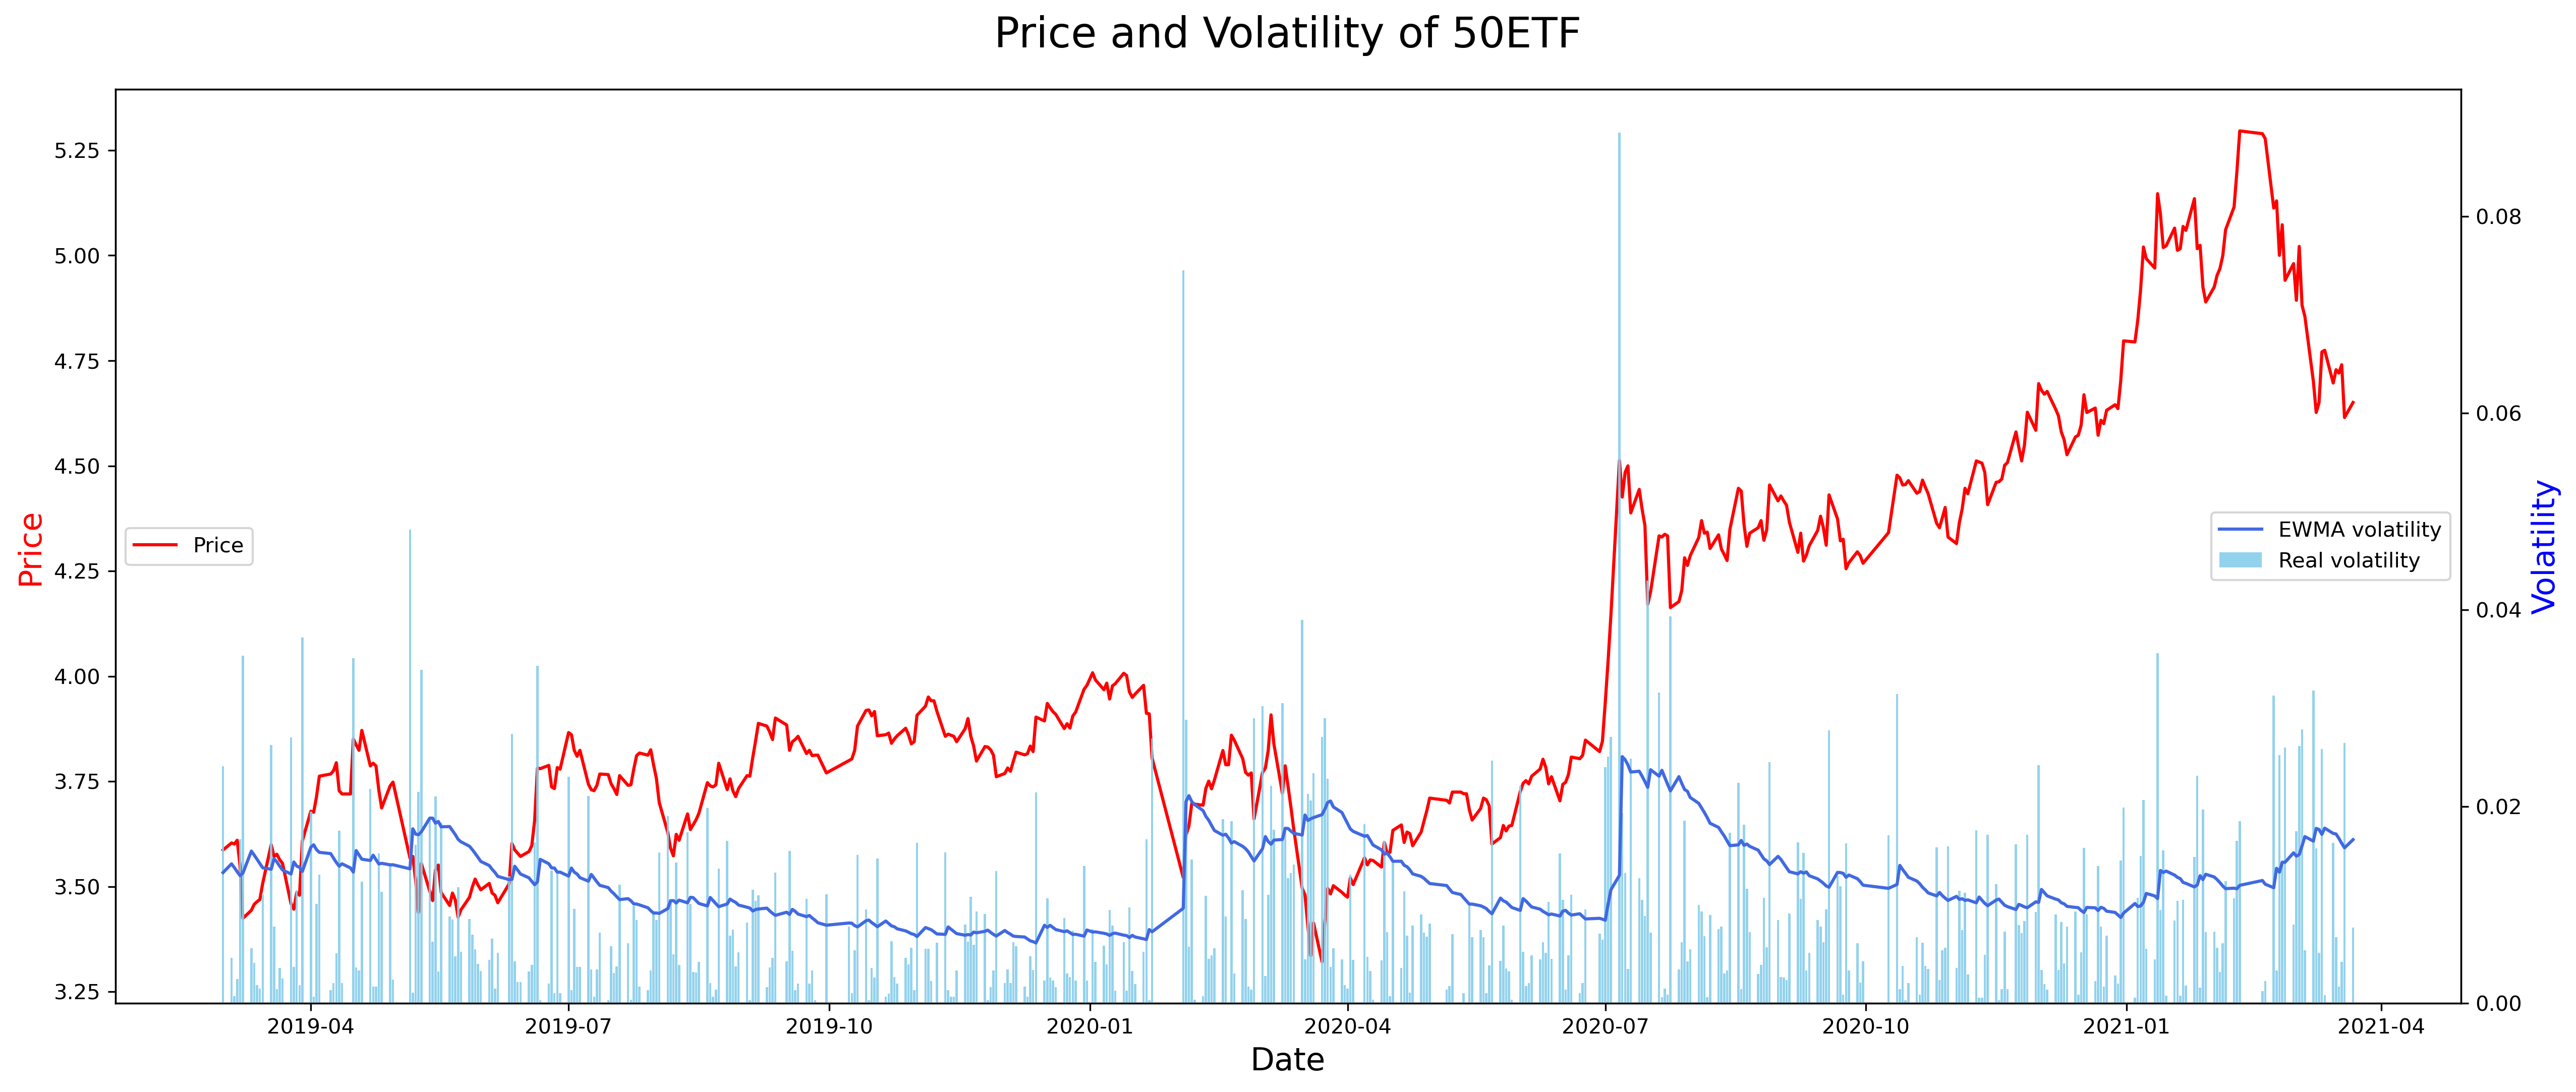

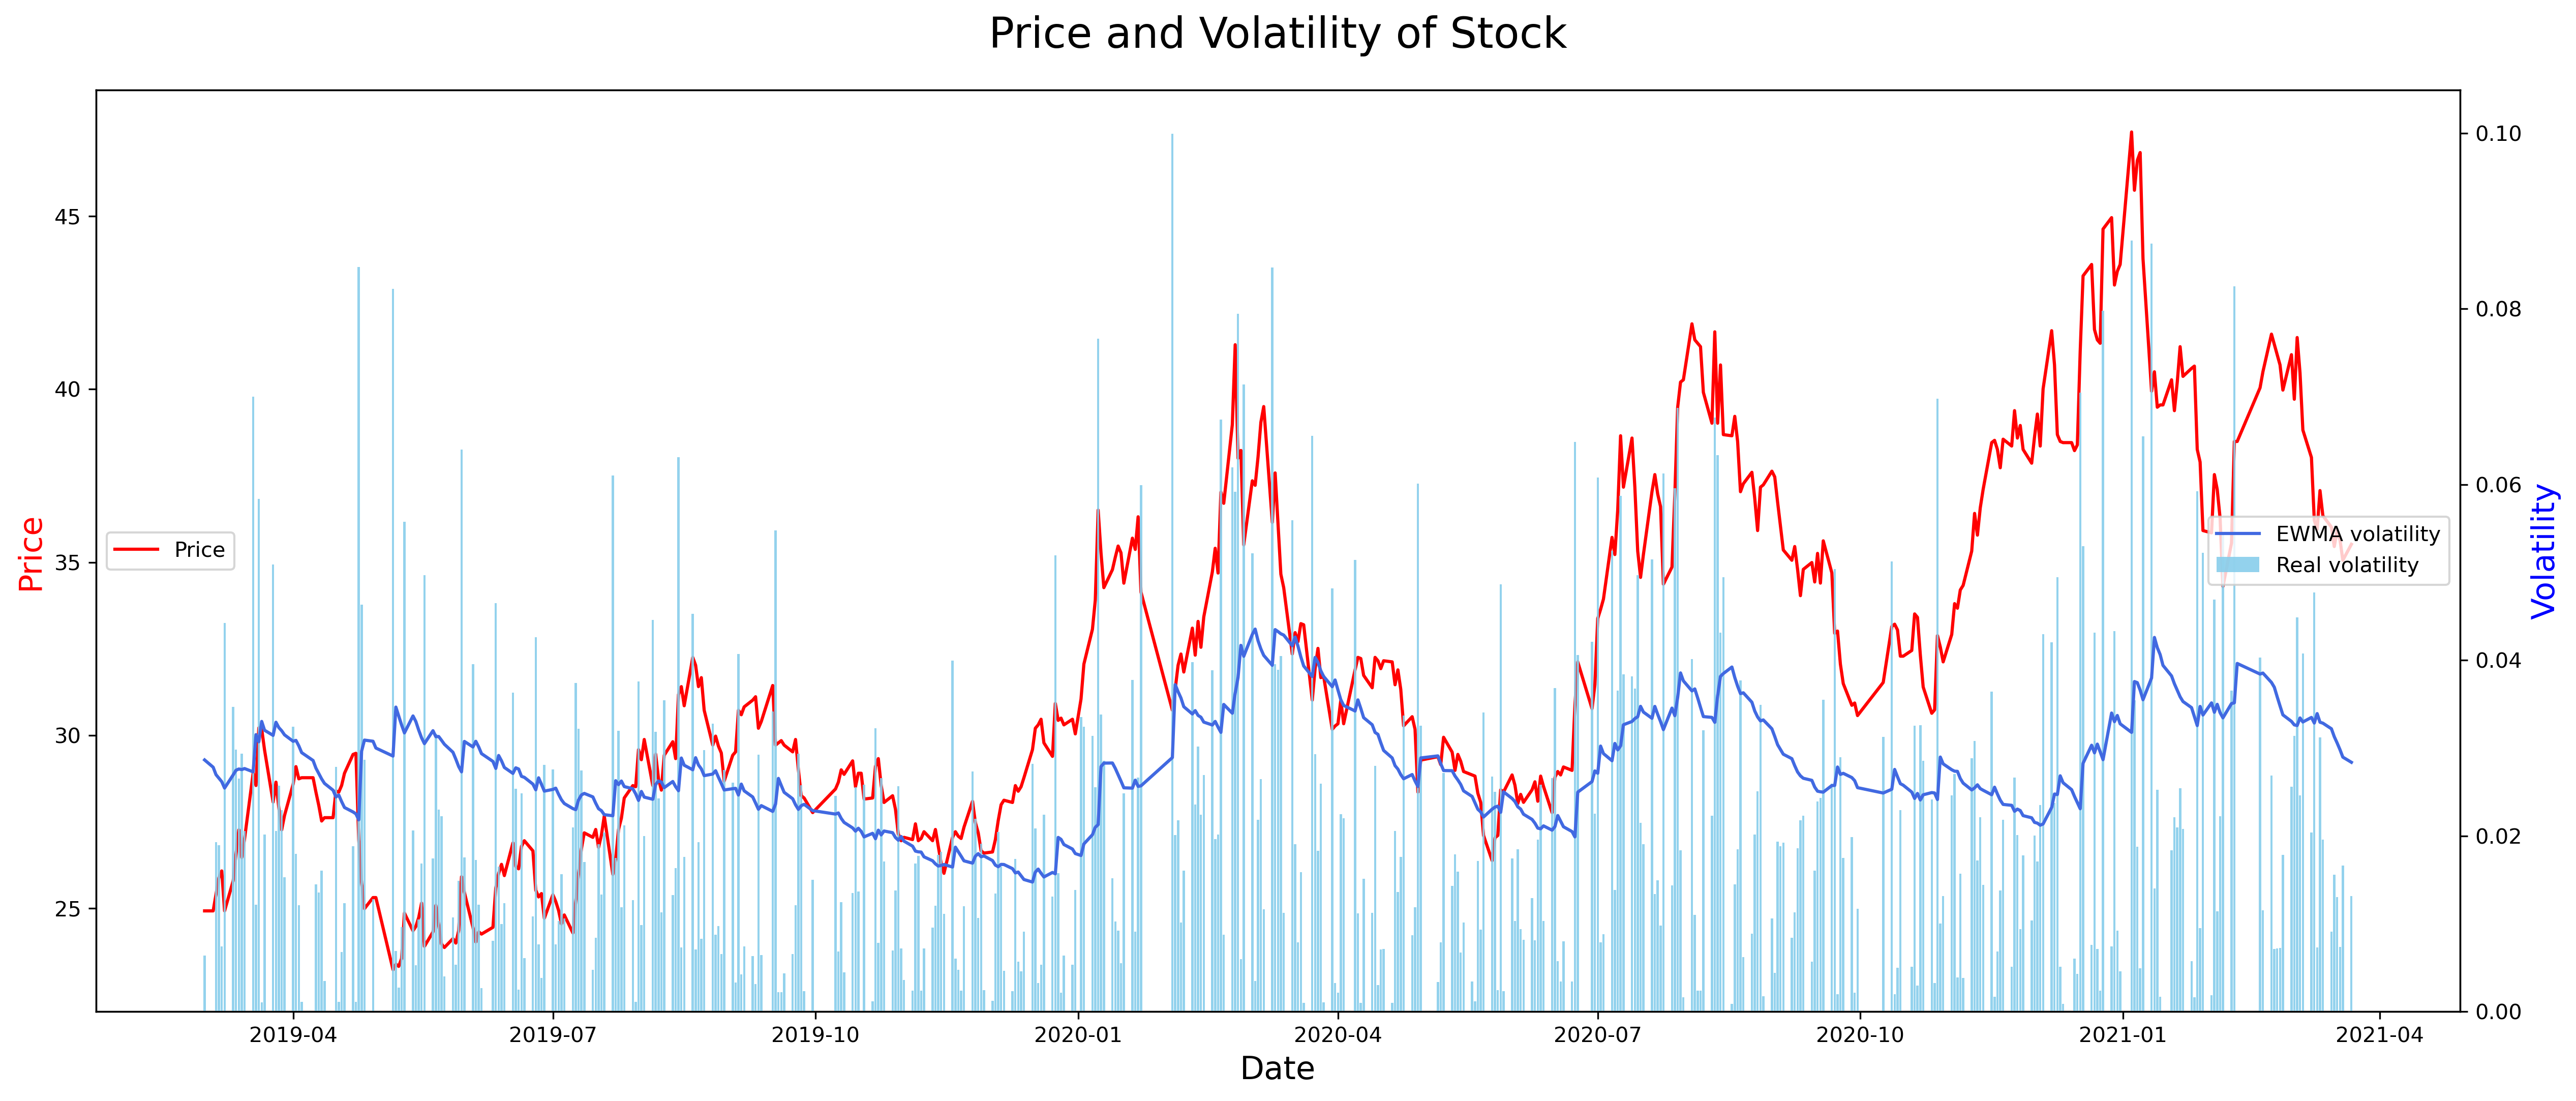

In [169]:
plt.plot(table_vol['TradingDate'],table_vol['ETF_vol'])
plt.plot(table_vol['TradingDate'],table_vol['comp_vol'])

figure = plt.figure(figsize=(20, 8), dpi=300)
ax1 = figure.add_subplot(111)
ax1.plot(table_vol['TradingDate'],table_vol['ComparablePrice'],color='red')
ax1.legend(['Price'],loc='center left')
ax2 = ax1.twinx()
ax2.bar(table_vol['TradingDate'],np.abs(table_vol['ReturnDaily']),color='skyblue',alpha=0.9)
ax2.plot(table_vol['TradingDate'],table_vol['ETF_vol'],color='royalblue')
ax1.set_ylabel("Price",fontsize=15,color='red')
ax2.set_ylabel("Volatility",fontsize=15,color='blue')
ax1.set_xlabel('Date',fontsize=15)
ax2.legend(['EWMA volatility','Real volatility'],loc='center right')
plt.title("Price and Volatility of 50ETF",fontsize=20,pad=20)

figure = plt.figure(figsize=(20, 8), dpi=300)
ax1 = figure.add_subplot(111)
ax1.plot(table_vol['TradingDate'],table_vol['Adjprcwd'],color='red')
ax1.legend(['Price'],loc='center left')
ax2 = ax1.twinx()
ax2.bar(table_vol['TradingDate'],np.abs(table_vol['Dretwd']),color='skyblue',alpha=0.9)
ax2.plot(table_vol['TradingDate'],table_vol['comp_vol'],color='royalblue')
ax1.set_ylabel("Price",fontsize=15,color='red')
ax2.set_ylabel("Volatility",fontsize=15,color='blue')
ax1.set_xlabel('Date',fontsize=15)
ax2.legend(['EWMA volatility','Real volatility'],loc='center right')
plt.title("Price and Volatility of Stock",fontsize=20,pad=20)

In [170]:
table_vol['ETF_PF']=list(table_vol['ComparablePrice'])[-1]*(1+table_vol['ReturnDaily']*list(table_vol['ETF_vol'])[-1]/table_vol['ETF_vol'])
table_vol['comp_PF']=list(table_vol['Adjprcwd'])[-1]*(1+table_vol['Dretwd']*list(table_vol['comp_vol'])[-1]/table_vol['comp_vol'])
                                                                                                                        

In [171]:
ETF_Value=500*table_vol['ETF_PF']/list(table_vol['ETF_PF'])[-1]
Comp_Value=500*table_vol['comp_PF']/list(table_vol['comp_PF'])[-1]
Tol_Value=ETF_Value+Comp_Value
Loss=1000-Tol_Value

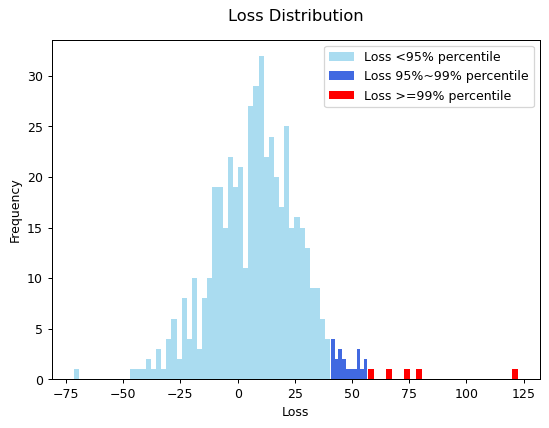

		 	VaR=56.93, ES=79.529


In [397]:
table_vol['Loss']=Loss
Loss_df=pd.DataFrame(Loss[:-1])
Loss_df['Weight']=np.ones(len(Loss_df))/len(Loss_df)
Loss_df.columns=['Loss','Weight']
a,b=VaR_ES(Loss_df,Alpha=0.99)

In [177]:
b.to_excel('/Users/jason/Desktop/EVT.xlsx')

In [178]:
Loss_df

Loss  Weight
0    -1.525782   0.002
1     7.629983   0.002
2     0.745187   0.002
3    -1.173586   0.002
4    16.956472   0.002
..         ...     ...
495  22.074733   0.002
496  14.064154   0.002
497   5.191343   0.002
498  11.652639   0.002
499  32.199434   0.002

[500 rows x 2 columns]

In [195]:
u

40.538303325405884

## 5. 极值理论

In [299]:
u=40
n=500
nu=len(b[b['Loss']>=u])
xi=0.245632645816618
beta=9.82190183583966
#P=nu/n*pow((1+xi*(x-u)/beta),-1/xi)

In [300]:
q=0.99
VaR=u+beta/xi*(pow(n*(1-q)/nu,-xi)-1)
ES=(VaR+beta-xi*u)/(1-xi)

In [ ]:
a,b=VaR_ES(Loss_df,Alpha=0.95,draw=False)
result_n=[]
result_evt=[]
for i in range(0,20):
    Alpha=0.9+i/200
    a,b=VaR_ES(Loss_df,Alpha,draw=False)
    VaR=u+beta/xi*(pow(n*(1-Alpha)/nu,-xi)-1)
    ES=(VaR+beta-xi*u)/(1-xi)
    result_n.append(a)
    result_evt.append([VaR,ES])

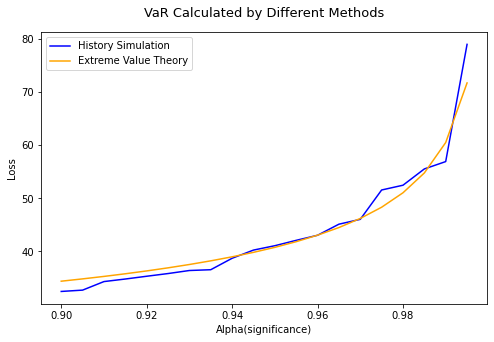

Text(0.5, 0, 'Alpha(significance)')

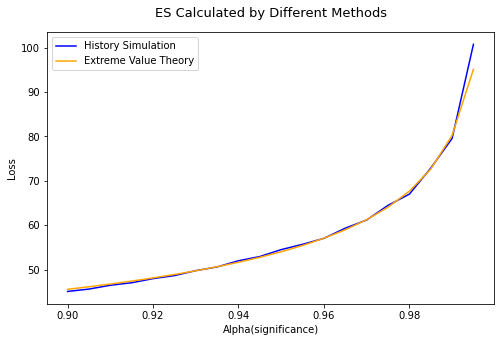

In [303]:
Alpha_list=[0.9+i/200 for i in range(0,20)]
#pd.DataFrame(result_n)
result_n_df=pd.DataFrame(result_n)
result_evt_df=pd.DataFrame(result_evt)
plt.figure(figsize=(8,5))
plt.plot(Alpha_list,result_n_df[0],color='blue')
plt.plot(Alpha_list,result_evt_df[0],color='orange')
plt.legend(['History Simulation','Extreme Value Theory'])
plt.title('VaR Calculated by Different Methods',fontsize=13,pad=15)
plt.ylabel('Loss')
plt.xlabel('Alpha(significance)')
plt.show()
plt.figure(figsize=(8,5))
plt.plot(Alpha_list,result_n_df[1],color='blue')
plt.plot(Alpha_list,result_evt_df[1],color='orange')
plt.legend(['History Simulation','Extreme Value Theory'])
plt.title('ES Calculated by Different Methods',fontsize=13,pad=15)
plt.ylabel('Loss')
plt.xlabel('Alpha(significance)')

In [410]:
def VaR_ES_evt(Loss_df,Alpha,u=40,A=1000,choice='ori',xi=0.2456,beta=9.8219):
    
    Prob=[]
    for x in range(u,int(np.ceil(max(Loss_df['Loss'])))):
        if choice=='ori':
            P=nu/n*pow((1+xi*(x-u)/beta),-1/xi)
        elif choice=='adj':
            if x==A:
                P=0
            else:
                k=x-u
                y=np.log((A-u+k)/(A-u-k))
                P=nu/n*pow((1+xi*y/beta),-1/xi)
        Prob.append(P)
    x=np.arange(u,max(Loss_df['Loss'])-1,1)
    freq=(np.array(Prob[:-1])-np.array(Prob[1:]))*40
    print(Prob)
    plt.figure(figsize=(7,5),dpi=90)
    ax1 = figure.add_subplot(111)
    plt.hist(Loss_df['Loss'][Loss_df['Loss']<=Loss_df['Loss'].quantile(0.95)],bins=50,color='skyblue',alpha=0.7)
    plt.hist(Loss_df['Loss'][(Loss_df['Loss']>=Loss_df['Loss'].quantile(0.95))& (Loss_df['Loss']<=Loss_df['Loss'].quantile(0.99))],bins=10,color='royalblue')
    plt.hist(Loss_df['Loss'][Loss_df['Loss']>=Loss_df['Loss'].quantile(0.99)],bins=25,color='red')
    #ax2=ax1.twinx()
    plt.bar(x,freq,color = 'purple')
    
    plt.title('Loss Distribution',fontsize=13,pad=15)
    plt.legend(['Loss <95% percentile','Loss 95%~99% percentile','Loss >=99% percentile','Extreme Value'])
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.show()
    
    Loss_sorted=Loss_df.sort_values(by=['Loss'],ascending=False)
    Loss_sorted['CumWeight']=Loss_sorted['Weight'].cumsum()
    Loss_over=Loss_sorted[Loss_sorted['CumWeight']<=1-Alpha]
    VaR=list(Loss_over['Loss'])[-1]
    ES=np.dot(Loss_over['Loss'],Loss_over['Weight'])/sum(Loss_over['Weight'])
    print('\t\t \tVaR={}, ES={}'.format(round(VaR,3),round(ES,3)))
    return [VaR,ES],Loss_sorted

[2.076923076923077, 1.878223384967243, 1.7026554020199733, 1.5470680179418888, 1.4087990493657616, 1.285590519175219, 1.1755200864056614, 1.0769452791112717, 0.9884579299919981, 0.9088467835623116, 0.8370666795213307, 0.772213052827063, 0.7135007511800117, 0.6602463732913274, 0.6118534899737786, 0.5678002349134954, 0.5276288506372462, 0.49093685352039407, 0.45736954414297054, 0.42661363931868024, 0.3983918423352414, 0.3724582004016749, 0.3485941245934316, 0.3266049689665584, 0.30631708295710774, 0.2875752654640998, 0.27024056074539343, 0.25418834592192424, 0.23930666787488422, 0.22549479394310498, 0.21266194633366153, 0.2007261947487354, 0.18961348556869945, 0.179256789147237, 0.16959534947649033, 0.16057402275642307, 0.15214269332457497, 0.14425575702907786, 0.13687166350773383, 0.12995251000912209, 0.12346368039126845, 0.11737352378683247, 0.11165306815392033, 0.10627576455755638, 0.10121725856447375, 0.09645518559653637, 0.09196898748698637, 0.08773974782821364, 0.08375004399782957,

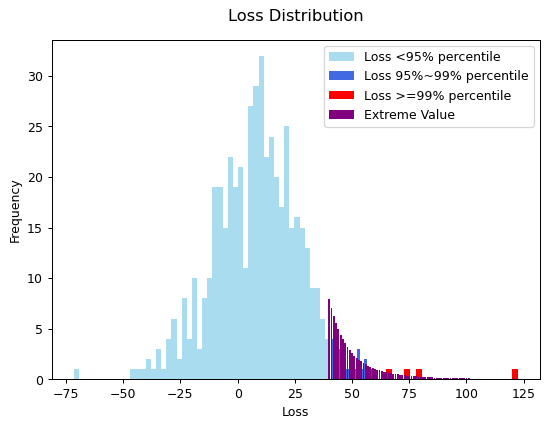

		 	VaR=56.93, ES=79.529


In [411]:
a,b=VaR_ES_evt(Loss_df,0.99,u=40,A=1000,choice='ori',xi=0.2456,beta=9.8219)

## 6. 误差的估计

count    500.000000
mean       8.990193
std       20.220769
min      -71.530974
25%       -3.849837
50%        9.384332
75%       21.418274
max      122.423711
Name: Loss, dtype: float64

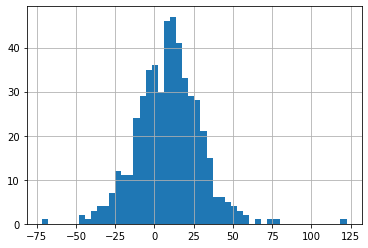

In [986]:
Loss_df['Loss'].hist(bins=50)
Loss_df['Loss'].describe()

In [987]:
from scipy import stats

In [994]:
def SE(VaR,q,n,Loss_df):
    fx=stats.norm.pdf(VaR,Loss_df['Loss'].mean(),Loss_df['Loss'].std())
    se=np.sqrt((1-q)*q/n)/fx
    return se

In [1003]:
#波动率调整的历史模拟法
VaR=56.93
ES=79.529
SE(56.93,0.99,500,Loss_df)

3.7476484818419142

In [1004]:
#极值理论
VaR=60.52137348876991
ES=80.2234735587899
SE(VaR,0.99,500,Loss_df)

5.800695893030289

## 7. 自助法

In [1287]:
Loss_df.head(5)

Loss  Weight
0  -1.525782   0.002
1   7.629983   0.002
2   0.745187   0.002
3  -1.173586   0.002
4  16.956472   0.002

In [1059]:
import random
result=[]
for k in range(0,10000):
    index_rand=[]
    for i in range(0,len(Loss_df)):
        index_rand.append(random.randint(0,499))
    boot_appro=Loss_df.loc[index_rand]
    L=boot_appro['Loss'].quantile(0.99)
    ES=np.mean(boot_appro['Loss'][boot_appro['Loss']>=L])
    
    result.append([L,ES])

In [1060]:
result_df=pd.DataFrame(result,columns=['VaR','ES'])


In [1288]:
result_df.head(5)

VaR         ES
0  57.017519  92.627430
1  56.721214  70.692195
2  53.424702  78.329029
3  54.240865  68.141299
4  57.017519  92.627430

(array([4.800e+01, 5.200e+01, 2.570e+02, 2.657e+03, 4.889e+03, 2.000e+00,
        0.000e+00, 0.000e+00, 1.284e+03, 0.000e+00, 0.000e+00, 6.540e+02,
        0.000e+00, 1.520e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00]),
 array([ 44.16074882,  46.76951423,  49.37827964,  51.98704505,
         54.59581046,  57.20457587,  59.81334128,  62.42210669,
         65.0308721 ,  67.63963751,  70.24840292,  72.85716833,
         75.46593374,  78.07469915,  80.68346457,  83.29222998,
         85.90099539,  88.5097608 ,  91.11852621,  93.72729162,
         96.33605703,  98.94482244, 101.55358785, 104.16235326,
        106.77111867, 109.37988408, 111.98864949, 114.5974149 ,
        117.20618031, 119.81494572, 122.42371113]),
 <BarContainer object of 30 artists>)

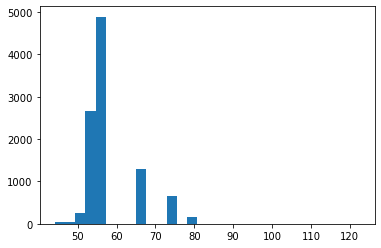

In [1062]:
plt.hist(result_df['VaR'],bins=30)

In [1063]:
result_df.describe().T.round(3)

count    mean     std     min     25%     50%     75%      max
VaR  10000.0  58.124   6.470  44.161  54.254  56.721  57.018  122.424
ES   10000.0  76.792  12.759  50.556  67.092  75.268  84.600  122.424

(array([ 135.,  652., 1157., 1255., 1560., 1347., 1238.,  895.,  641.,
         504.,  262.,  234.,   28.,   63.,   29.]),
 array([ 50.55632178,  55.34748107,  60.13864036,  64.92979965,
         69.72095894,  74.51211823,  79.30327752,  84.09443681,
         88.8855961 ,  93.67675539,  98.46791468, 103.25907397,
        108.05023326, 112.84139255, 117.63255184, 122.42371113]),
 <BarContainer object of 15 artists>)

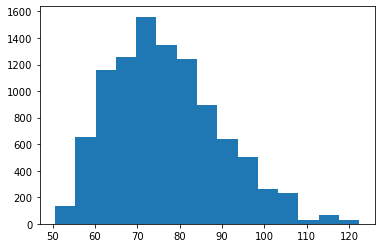

In [1064]:
plt.hist(result_df['ES'],bins=15)

# 四. 模型构建法

In [1289]:
table_split.head(5)

TradingDate  ReturnDaily  ComparablePrice      Trddt    Dretwd   Adjprcwd  \
0  2019-03-01     0.024123         3.587011 2019-03-01 -0.006386  24.930976   
1  2019-03-04     0.004640         3.603654 2019-03-04  0.000000  24.930976   
2  2019-03-05    -0.000710         3.601096 2019-03-05  0.019280  25.411650   
3  2019-03-06     0.002488         3.610055 2019-03-06  0.018916  25.892324   
4  2019-03-07    -0.016667         3.549886 2019-03-07  0.007426  26.084594   

    ETF_vol  comp_vol    ETF_PF    comp_PF       Loss  
0  0.013293  0.028647  4.790895  35.293392  -1.525782  
1  0.014178  0.027818  4.675819  35.518079   7.629983  
2  0.013793  0.026971  4.646518  36.238588   0.745187  
3  0.013374  0.026572  4.664892  36.235589  -1.173586  
4  0.012981  0.026176  4.551165  35.804020  16.956472

In [1067]:
temp=np.cov(table_split['ReturnDaily'],table_split['Dretwd'])
vol_etf=[temp[0,0]]
vol_comp=[temp[1,1]]
vol_cov=[temp[0,1]]
for i in range(1,len(table_split)):
    vol_etf.append(Lambda*vol_etf[i-1]+(1-Lambda)*list(table_split['ReturnDaily'])[i]**2)
    vol_comp.append(Lambda*vol_comp[i-1]+(1-Lambda)*list(table_split['Dretwd'])[i]**2)
    vol_cov.append(Lambda*vol_cov[i-1]+(1-Lambda)*list(table_split['Dretwd'])[i]*list(table_split['ReturnDaily'])[i])

In [1073]:
temp

array([[0.00017706, 0.00018375],
       [0.00018375, 0.00082228]])

Text(0.5, 1.0, 'Covariance of 50ETF and Stock')

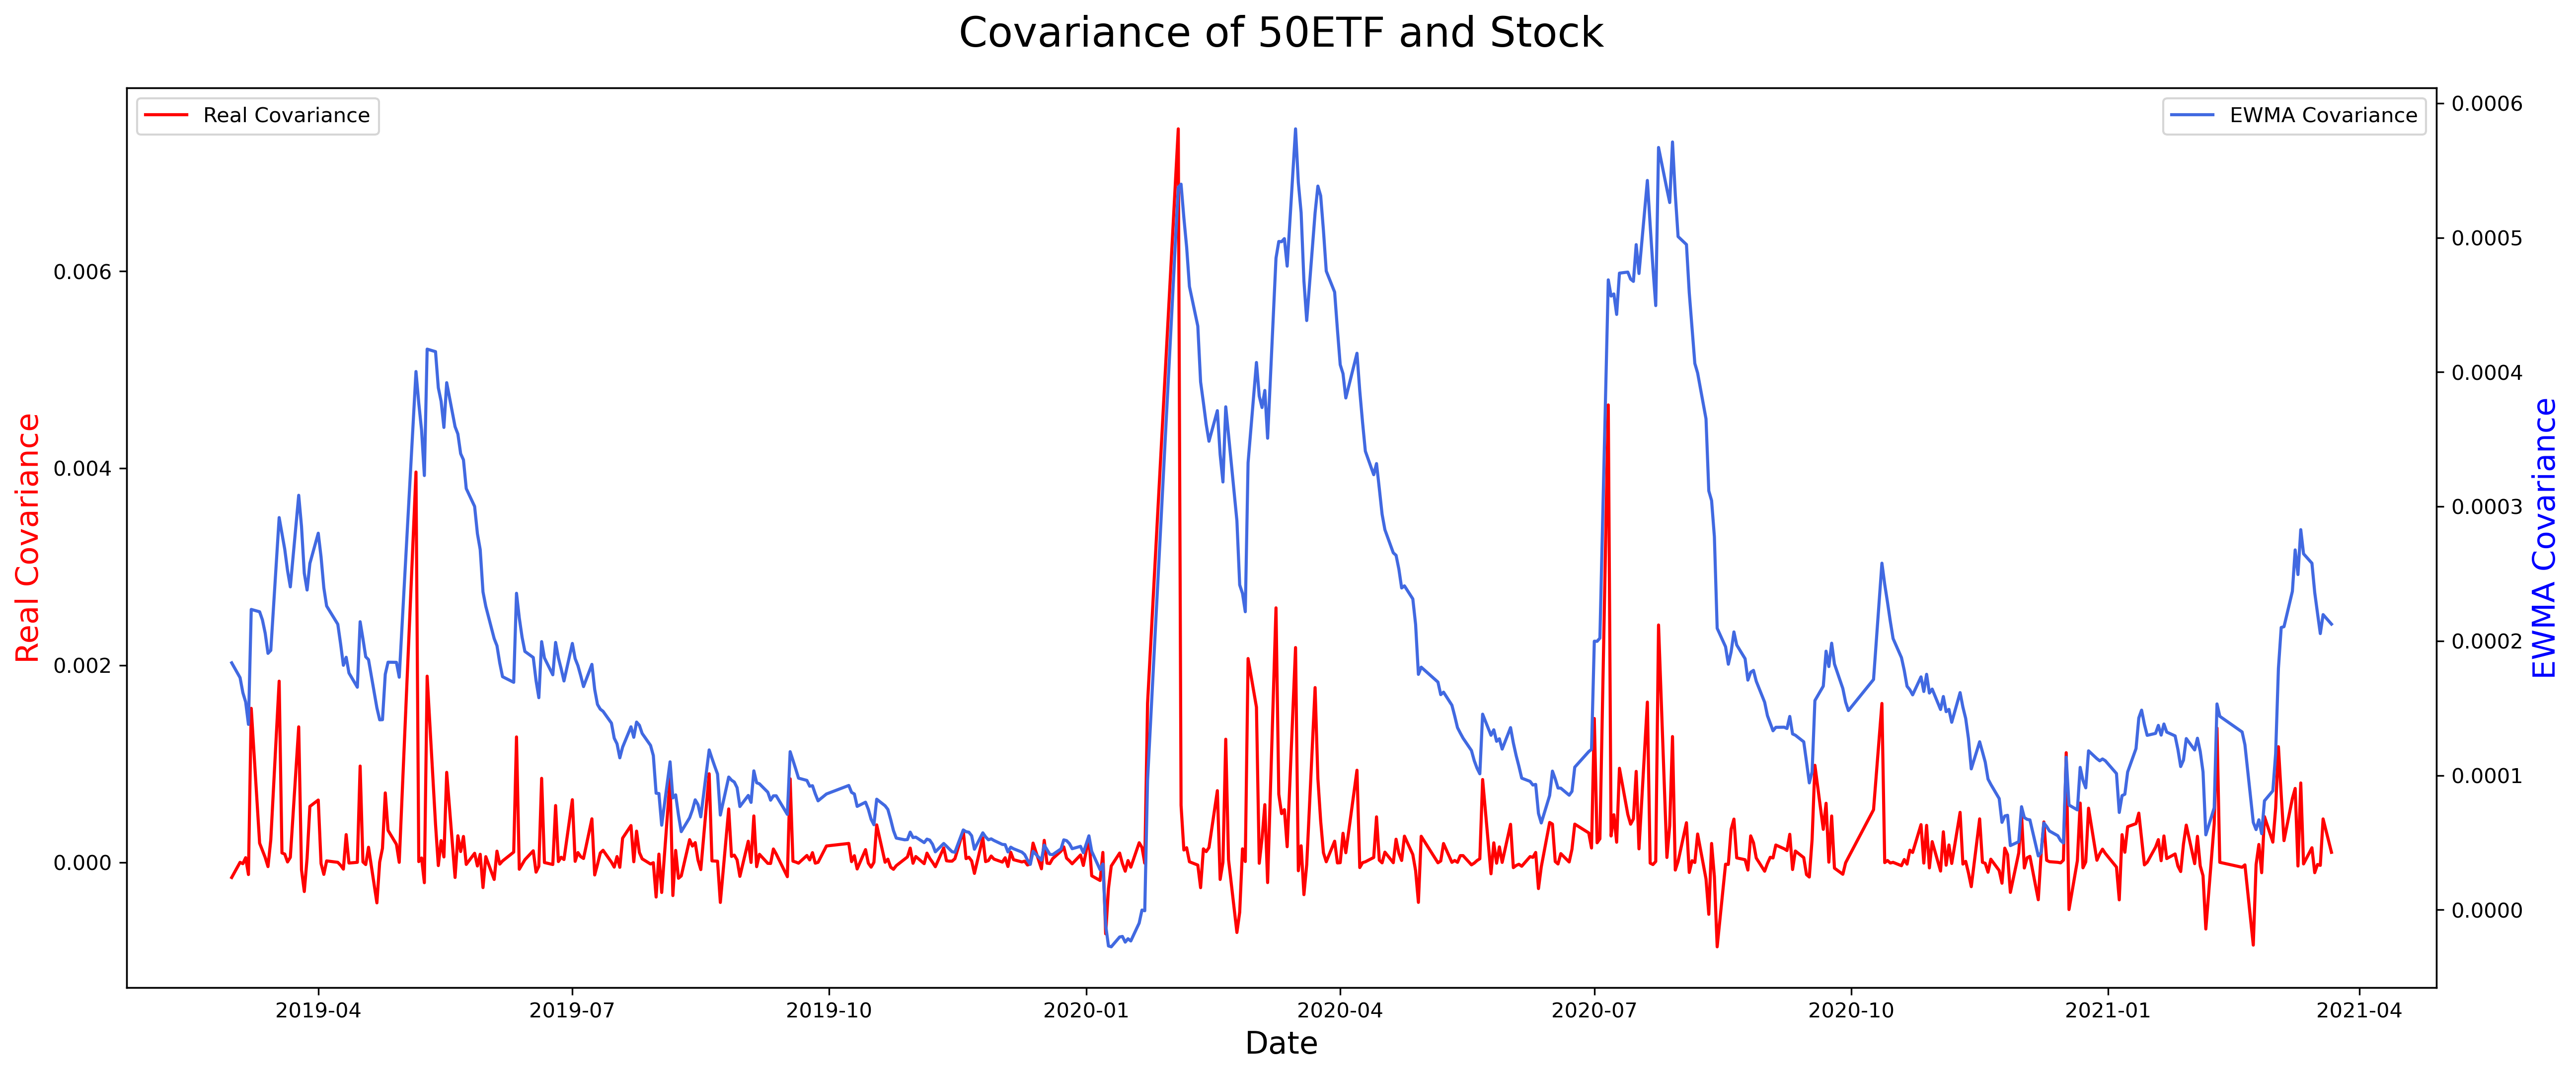

In [1077]:
figure = plt.figure(figsize=(20, 8), dpi=300)
ax1 = figure.add_subplot(111)
ax1.plot(table_split['TradingDate'],table_split['ReturnDaily']*table_split['Dretwd'],color='red')
ax1.legend(['Real Covariance'],loc='upper left')
ax2 = ax1.twinx()
ax2.plot(table_split['TradingDate'],vol_cov,color='royalblue')
ax1.set_ylabel("Real Covariance",fontsize=15,color='red')
ax2.set_ylabel("EWMA Covariance",fontsize=15,color='blue')
ax1.set_xlabel('Date',fontsize=15)
ax2.legend(['EWMA Covariance'],loc='upper right')
plt.title("Covariance of 50ETF and Stock",fontsize=20,pad=20)

In [1131]:
def corr_vol(var_mat):
    vol_mat=np.sqrt(var_mat)
    vol=[1/vol_mat[0][0],1/vol_mat[1][1]]
    corr_mat=np.eye(2)
    corr_mat[0][0]=var_mat[0][0]*vol[0]**2
    corr_mat[1][1]=var_mat[1][1]*vol[1]**2
    corr_mat[1][0]=var_mat[1][0]*vol[1]*vol[0]
    corr_mat[0][1]=var_mat[0][1]*vol[1]*vol[0]
    return var_mat,vol_mat,corr_mat

In [1157]:
var_mat=[[vol_etf[-1],vol_cov[-1]],[vol_cov[-1],vol_comp[-1]]]
a1,b1,c1=corr_vol(var_mat)

In [1143]:
c=np.mean(table_split['ReturnDaily']*table_split['Dretwd'][:-1])
a=np.mean(table_split['ReturnDaily']*table_split['ReturnDaily'][:-1])
b=np.mean(table_split['Dretwd']*table_split['Dretwd'][:-1])
var_mat=[[a,c],[c,b]]
a2,b2,c2=corr_vol(var_mat)

In [1158]:
var_mat=[[vol_etf[-1],vol_cov[-1]],[vol_cov[-1],vol_comp[-1]]]
w=np.array([500,500])

In [1159]:
port_vol=np.sqrt(np.dot(np.dot(w,var_mat),w))

In [1160]:
port_vol

19.080049261758926

In [1162]:
VaR=2.33*port_vol
ES=port_vol*(np.exp(-2.33**2/2)/(np.sqrt(2*np.pi)*(0.01)))

In [1164]:
print(VaR,ES)

44.4565147798983 50.42186451029115


In [1325]:
#CF展开

In [1165]:
deltaP_etf=table_split['ComparablePrice'][:-1]*table_split['ReturnDaily'][:-1]
deltaP_comp=table_split['Adjprcwd'][:-1]*table_split['Dretwd'][:-1]

0.4143749003344347


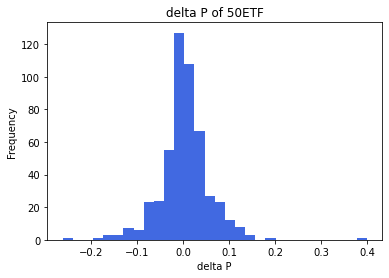

In [1171]:
plt.hist(deltaP_etf,bins=30,color='royalblue')
plt.title('delta P of 50ETF')
plt.xlabel('delta P')
plt.ylabel('Frequency')
print(deltaP_etf.skew())

0.15003555904042454


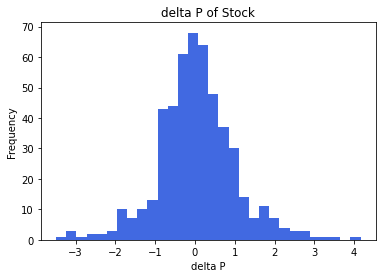

In [1172]:
plt.hist(deltaP_comp,bins=30,color='royalblue')
plt.title('delta P of Stock')
plt.xlabel('delta P')
plt.ylabel('Frequency')
print(deltaP_comp.skew())

In [1173]:
VaR_CF=(2.33+1/6*(2.33**2-1)*(0.41+0.15)/2)*port_vol

In [1174]:
VaR_CF

48.400017521417155

# 五. 模型的检验

In [1182]:
table_split2=table.iloc[500:,:]

In [1201]:
V1=500*np.array(list(table_split2['ComparablePrice']))[1:]/np.array(list(table_split2['ComparablePrice']))[:-1]
V2=500*np.array(list(table_split2['Adjprcwd']))[1:]/np.array(list(table_split2['Adjprcwd']))[:-1]
V=V1+V2
Loss=1000-V

Text(0, 0.5, 'Frequency')

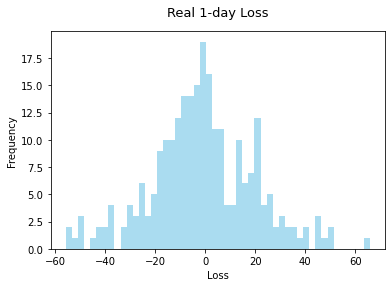

In [1206]:
plt.hist(Loss,bins=50,color='skyblue',alpha=0.7)
plt.title('Real 1-day Loss',fontsize=13,pad=15)
plt.xlabel('Loss')
plt.ylabel('Frequency')

Text(0.5, 1.0, 'Price and Volatility of 50ETF')

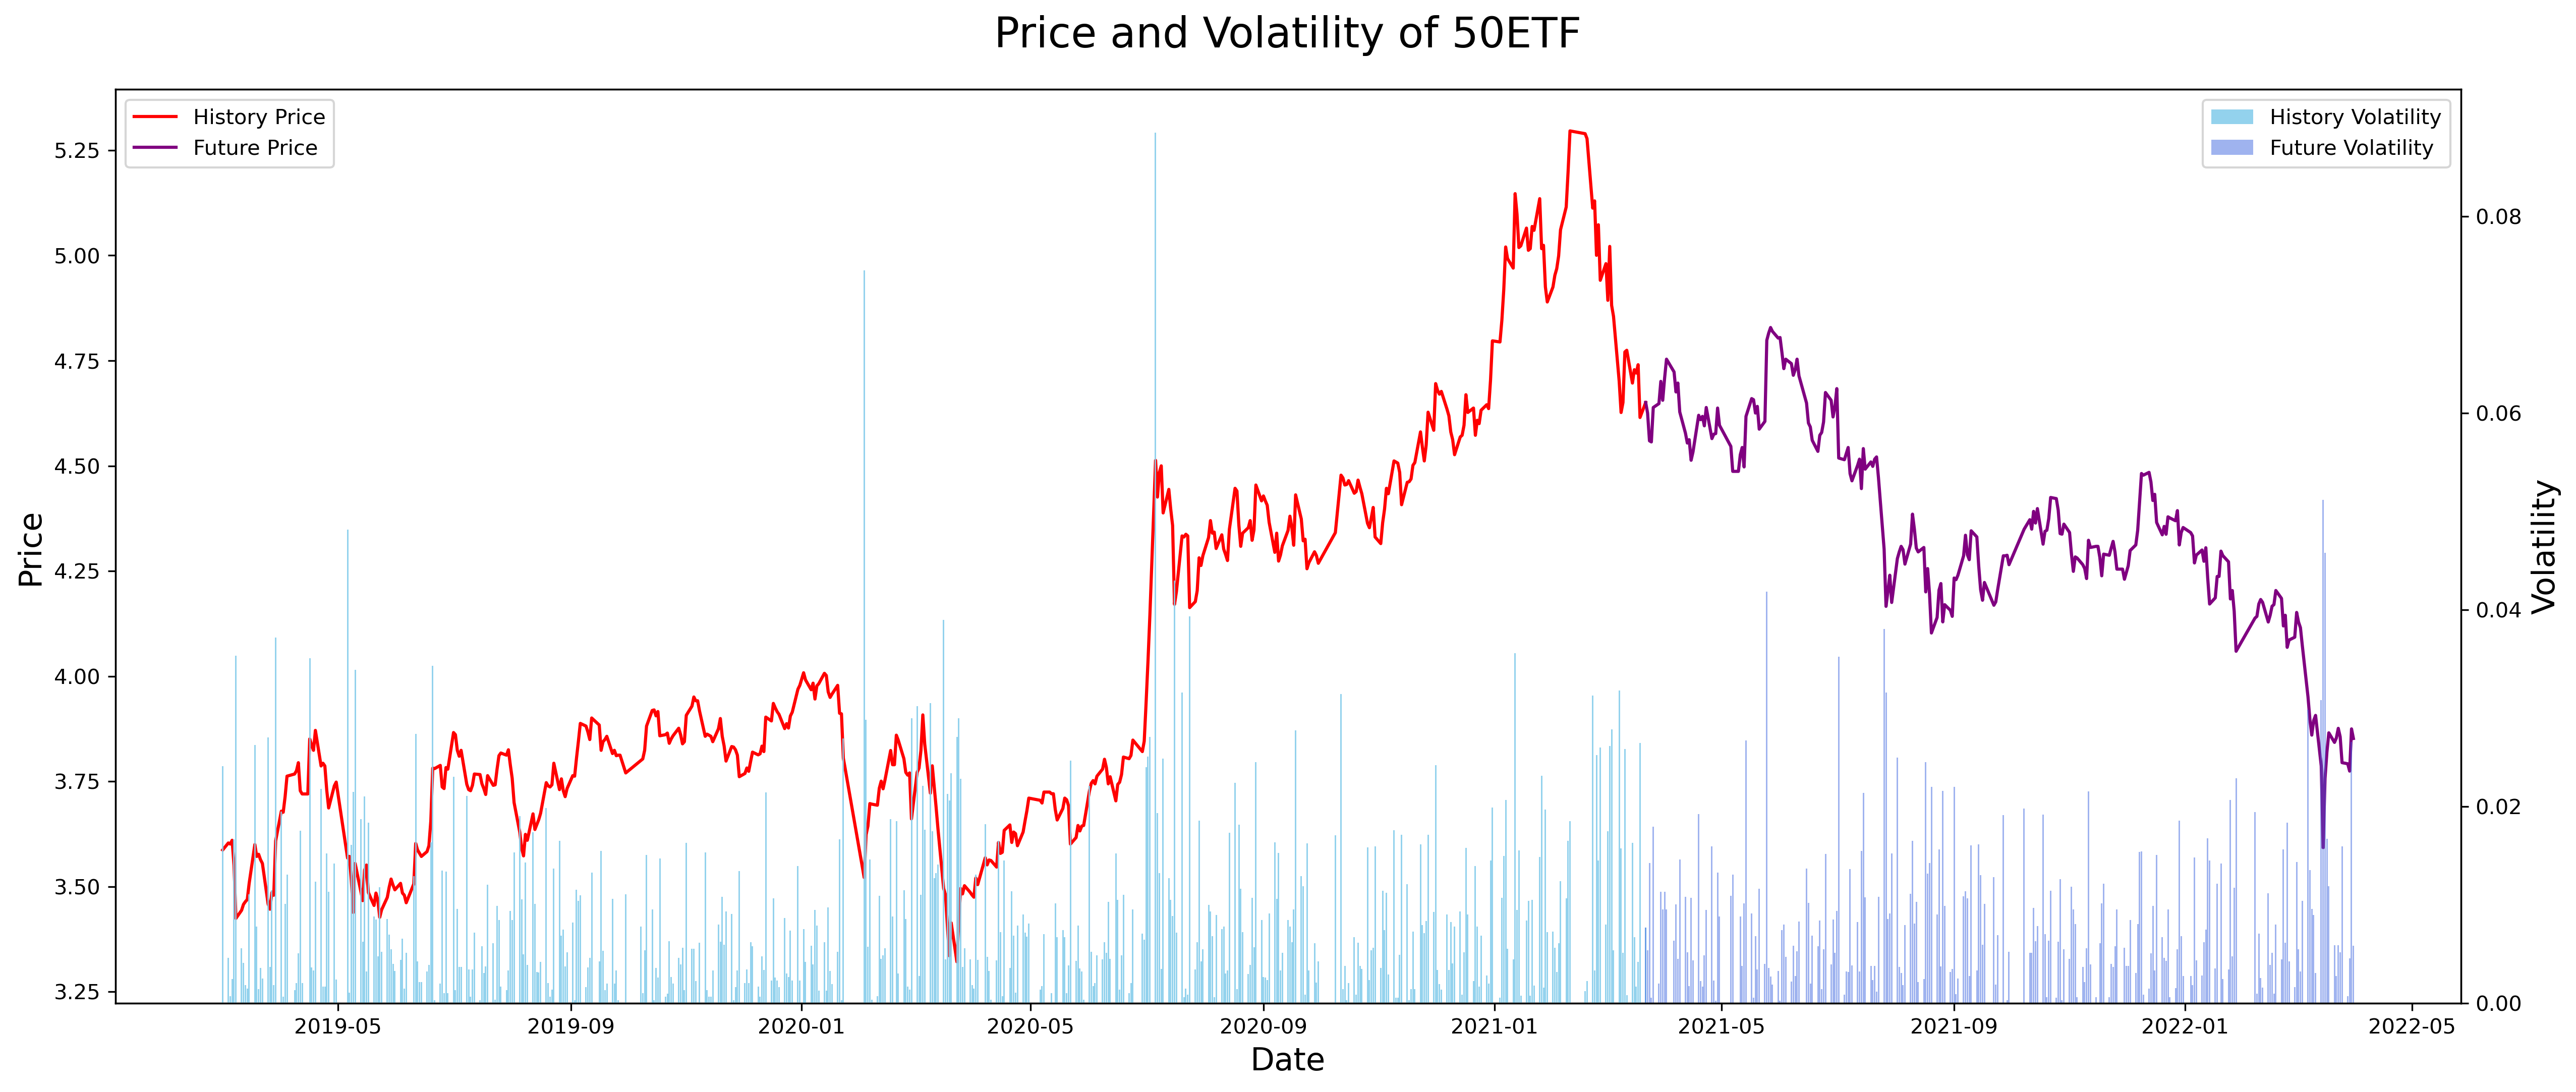

In [1217]:
table['TradingDate']=pd.to_datetime(table['TradingDate'])
ts1=table.iloc[0:501,:]
ts2=table.iloc[500:,:]

figure = plt.figure(figsize=(20, 8), dpi=300)
ax1 = figure.add_subplot(111)
ax1.plot(ts1['TradingDate'],ts1['ComparablePrice'],color='red')
ax1.plot(ts2['TradingDate'],ts2['ComparablePrice'],color='purple')
ax1.legend(['History Price','Future Price'],loc='upper left')

ax2 = ax1.twinx()

ax2.bar(ts1['TradingDate'],np.abs(ts1['ReturnDaily']),color='skyblue',alpha=0.9)
ax2.bar(ts2['TradingDate'],np.abs(ts2['ReturnDaily']),color='royalblue',alpha=0.5)

ax1.set_ylabel("Price",fontsize=15)
ax2.set_ylabel("Volatility",fontsize=15)
ax1.set_xlabel('Date',fontsize=15)
ax2.legend(['History Volatility','Future Volatility'],loc='upper right')
plt.title("Price and Volatility of 50ETF",fontsize=20,pad=20)



Text(0.5, 1.0, 'Price and Volatility of Stock')

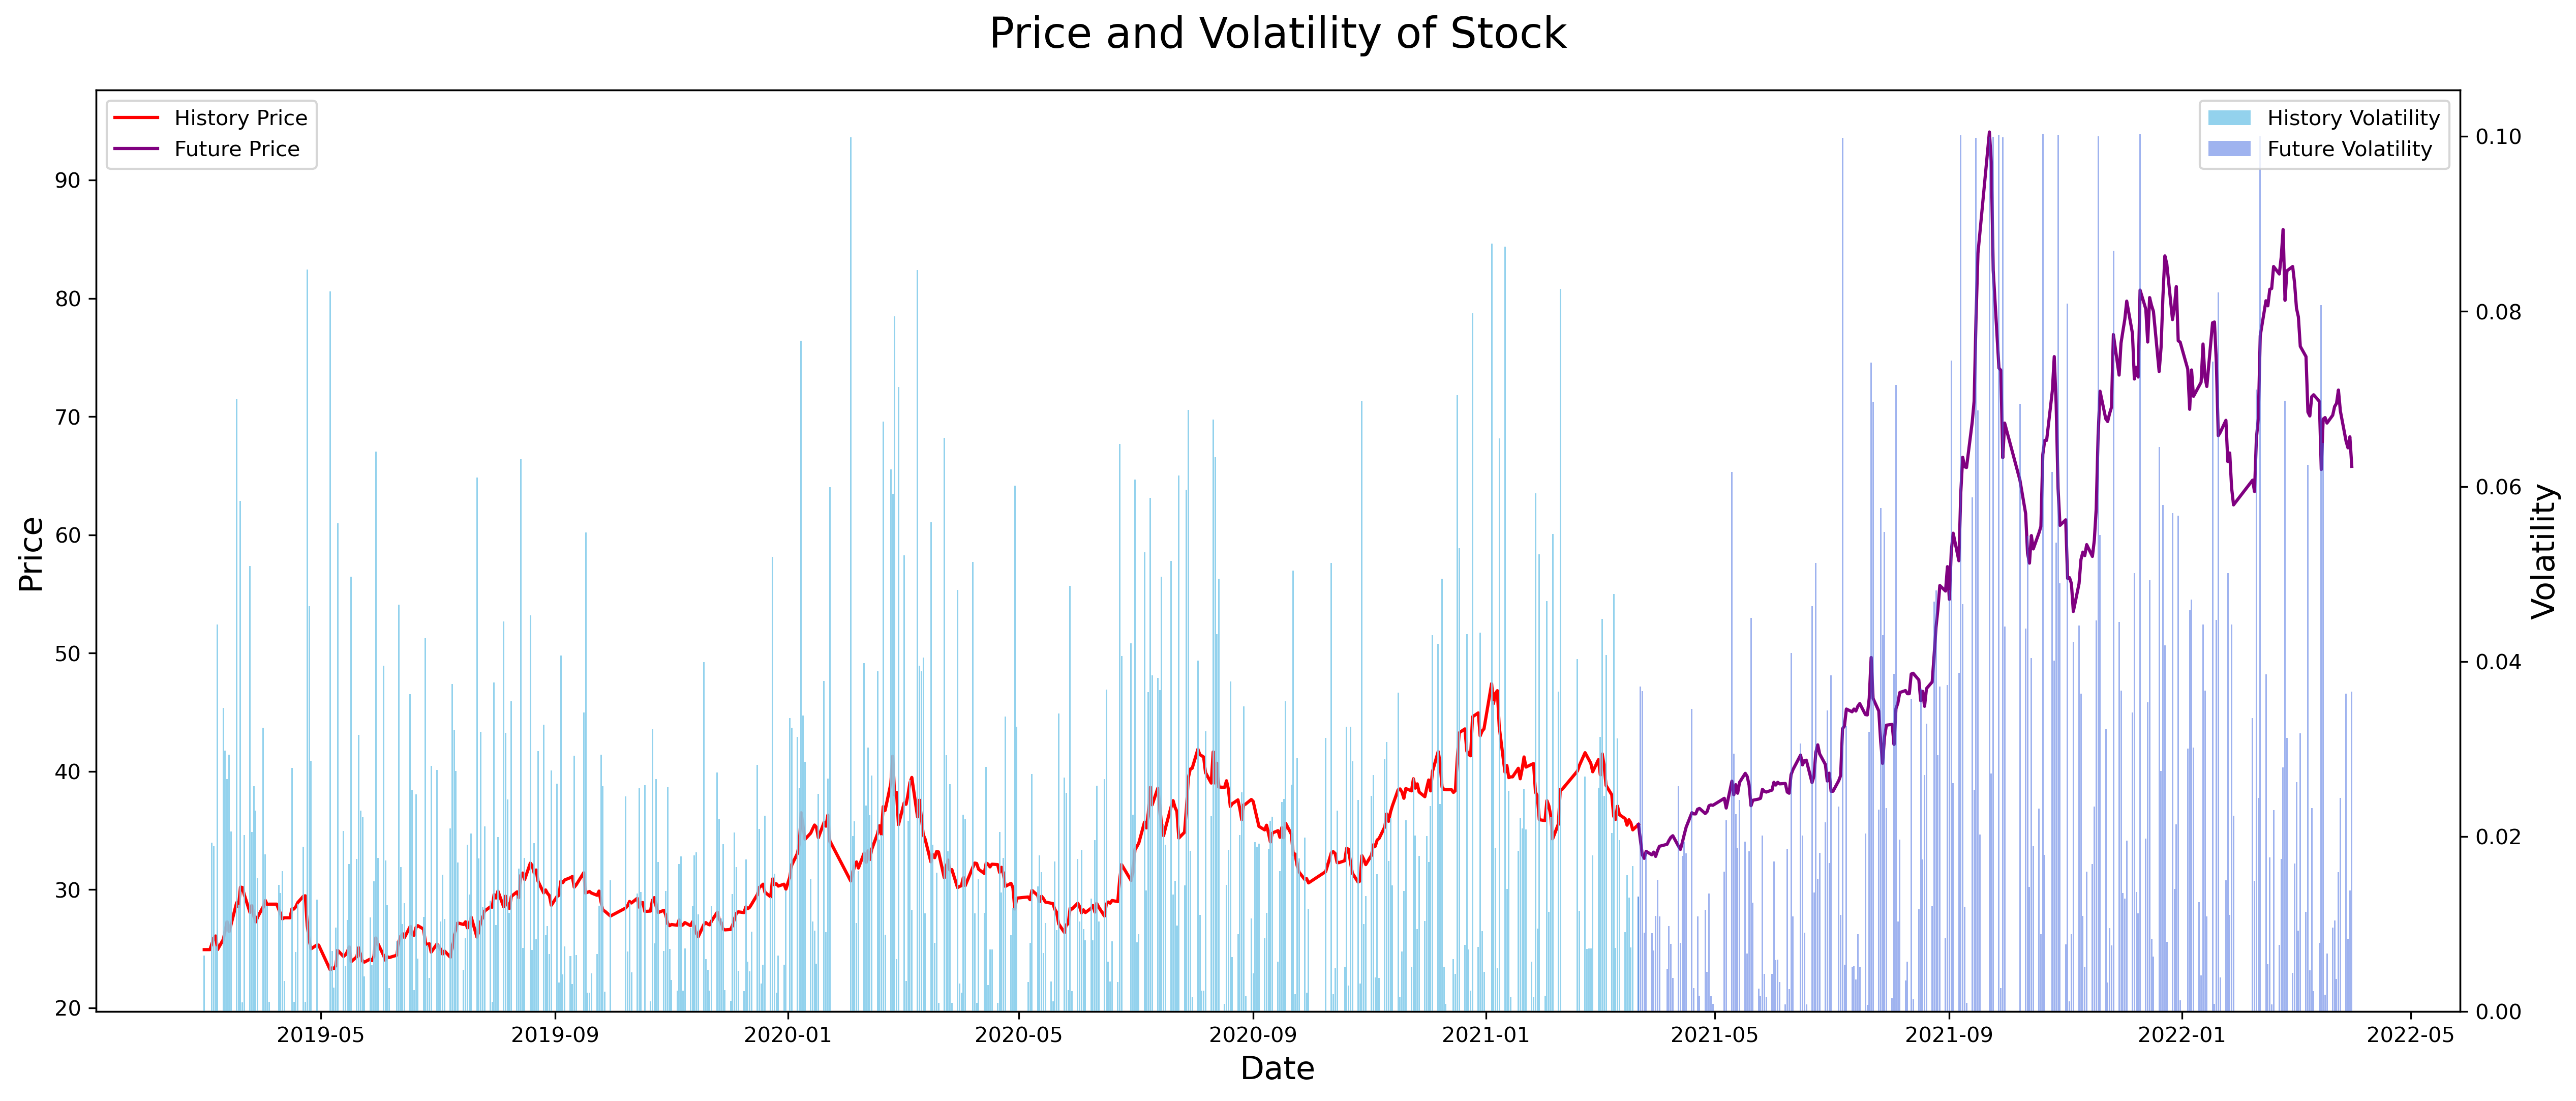

In [1219]:
table['TradingDate']=pd.to_datetime(table['TradingDate'])
ts1=table.iloc[0:501,:]
ts2=table.iloc[500:,:]

figure = plt.figure(figsize=(20, 8), dpi=300)
ax1 = figure.add_subplot(111)
ax1.plot(ts1['TradingDate'],ts1['Adjprcwd'],color='red')
ax1.plot(ts2['TradingDate'],ts2['Adjprcwd'],color='purple')
ax1.legend(['History Price','Future Price'],loc='upper left')

ax2 = ax1.twinx()

ax2.bar(ts1['TradingDate'],np.abs(ts1['Dretwd']),color='skyblue',alpha=0.9)
ax2.bar(ts2['TradingDate'],np.abs(ts2['Dretwd']),color='royalblue',alpha=0.5)

ax1.set_ylabel("Price",fontsize=15)
ax2.set_ylabel("Volatility",fontsize=15)
ax1.set_xlabel('Date',fontsize=15)
ax2.legend(['History Volatility','Future Volatility'],loc='upper right')
plt.title("Price and Volatility of Stock",fontsize=20,pad=20)



In [1262]:
def model_test(VaR,alpha=0.99):
    p=1-alpha
    m=len(Loss[Loss>=VaR])
    n=len(Loss)
    t=-2*np.log(pow(1-p,n-m)*pow(p,m))+2*np.log(pow(1-m/n,n-m)*pow(m/n,m))
    p=1-stats.chi2.cdf(t,df=1)
    return [p,t,m/n]

In [1263]:

model_test(70,alpha=0.99)

[0.024981503053449705, 5.025167926750725, 0.0]

In [1249]:
Result=[['VaR','ES'],
['时间加权历史模拟法',47.454 ,57.530 ],
['波动率调整历史模拟法',56.930 ,79.529 ],
['极值理论',60.521 ,80.224 ],
['Bootstrap',61.268 ,78.380 ],
['模型构建法',44.457 ,50.422] ,
['考虑偏态分布的模型构建法',48.400 ,np.nan]]

In [1264]:
Result_df

0       1       2
0           VaR      ES     NaN
1     时间加权历史模拟法  47.454  57.530
2    波动率调整历史模拟法   56.93  79.529
3          极值理论  60.521  80.224
4     Bootstrap  61.268  78.380
5         模型构建法  44.457  50.422
6  考虑偏态分布的模型构建法    48.4     NaN

In [1269]:
Result_df=pd.DataFrame(Result)
R=[]
for i in range(0,len(Result_df)-1):
    temp=model_test(Result_df[1][i+1],alpha=0.99)
    R.append([Result_df[0][i+1]]+[Result_df[1][i+1]]+temp)

In [1274]:
R_df=pd.DataFrame(R).round(3)
R_df.columns=['方法','VaR','p-value','t-value','真实数据中超过VaR样本比例']

In [1280]:
R_df.sort_values(['VaR'])

方法     VaR  p-value  t-value  真实数据中超过VaR样本比例
4         模型构建法  44.457    0.059    3.555           0.024
0     时间加权历史模拟法  47.454    0.758    0.095           0.012
5  考虑偏态分布的模型构建法  48.400    0.758    0.095           0.012
1    波动率调整历史模拟法  56.930    0.278    1.176           0.004
2          极值理论  60.521    0.278    1.176           0.004
3     Bootstrap  61.268    0.278    1.176           0.004

In [20]:
pip install pyswarm

  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4479 sha256=c77b9550f9909df9674d24b1d33f56dddf808fd15925d1759c8a15a96e638485
  Stored in directory: /Users/jason/Library/Caches/pip/wheels/3b/48/7f/a9f4beb272837304aa8e55fda9c9b4243d23517d5b1349b052
Successfully built pyswarm
Note: you may need to restart the kernel to use updated packages.


In [38]:
import pandas as pd
a=pd.DataFrame([1,2])

In [41]:
from scipy.optimize import minimize
import numpy as np
import pyswarm
from pyswarm import pso

def object_func(x,a):
    Sum=a.iloc[0,0]
    for i in range(0,10):
        Sum=Sum+x[0]+x[1]
    
    return Sum
    #return (4+0.3*x[0]+0.0007*x[0]*x[0]+3+0.32*x[1]+0.0004*x[1]*x[1]+3.5+0.3*x[2]+0.00045*x[2]*x[2])

#不等式约束

def cons1(x,a):
    return [x[0]+x[1]+x[2]-700]

lb = [100, 120, 150]#
ub = [200, 250, 300]

xopt, fopt = pso(object_func,lb,ub,ieqcons=[cons1], maxiter=10,swarmsize=1000,args=[a])
print(xopt)
print(fopt)



Stopping search: maximum iterations reached --> 10
[150.00256491 250.         300.        ]
4001.025649077239


In [29]:
help(pso)

Help on function pso in module pyswarm.pso:

pso(func, lb, ub, ieqcons=[], f_ieqcons=None, args=(), kwargs={}, swarmsize=100, omega=0.5, phip=0.5, phig=0.5, maxiter=100, minstep=1e-08, minfunc=1e-08, debug=False)
    Perform a particle swarm optimization (PSO)
    
    Parameters
    func : function
        The function to be minimized
    lb : array
        The lower bounds of the design variable(s)
    ub : array
        The upper bounds of the design variable(s)
    
    Optional
    ieqcons : list
        A list of functions of length n such that ieqcons[j](x,*args) >= 0.0 in 
        a successfully optimized problem (Default: [])
    f_ieqcons : function
        Returns a 1-D array in which each element must be greater or equal 
        to 0.0 in a successfully optimized problem. If f_ieqcons is specified, 
        ieqcons is ignored (Default: None)
    args : tuple
        Additional arguments passed to objective and constraint functions
        (Default: empty tuple)
    kwargs 

In [48]:
np.random.randn()

0.3929850900670248

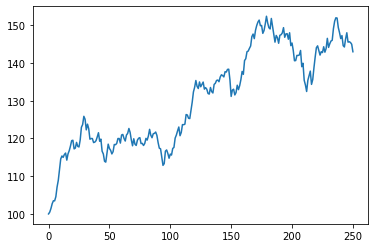

In [73]:
miu=0.3/250
sigma=0.2
S0=100
S=[S0]
deltat=1/250
for i in range(0,250):
    ds=S[i]*miu+sigma*S[i]*np.random.randn()*np.sqrt(deltat)
    S1=S[i]+ds
    S.append(S1)
plt.plot(S)

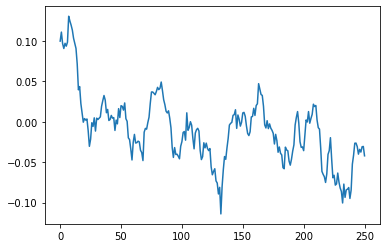

In [349]:
miu=0.3/250
sigma=0.2
S0=0.1
S=[S0]
deltat=1/250
for i in range(0,250):
    ds=sigma*np.random.randn()*np.sqrt(deltat)
    S1=S[i]+ds
    S.append(S1)
plt.plot(S)

In [367]:
a=-1000*(pd.DataFrame(np.array(S)[1:])/pd.DataFrame(np.array(S)[:-1])-1)
a.columns=['Loss']
a['Weight']=np.ones(250)*1/250

In [368]:
Loss_df=a
xi=0.245632645816618
beta=9.82190183583966
u=Loss_df['Loss'].quantile(0.95)
n=len(Loss_df[Loss_df['Loss']>=u])
cal_df=Loss_df[Loss_df['Loss']>=u]
def ML(x):
    return np.log((1/beta)*np.power((1+xi*(x-u)/beta),-1/xi-1))
cal_df['ML_val']=cal_df['Loss'].apply(ML)
ML_val_sum=np.sum(cal_df['ML_val'])
ML_val_sum

-339.382558602934

In [ ]:
#不等式约束

#def cons1(x,a):
#    return [x[0]+x[1]+x[2]-700]

lb = [0,0]#
#ub = [200, 250, 300]

xopt, fopt = pso(object_func,lb,ub,ieqcons=[cons1], maxiter=10,swarmsize=1000,args=[a])
print(xopt)
print(fopt)

In [372]:
from scipy.optimize import minimize
import numpy as np
import pyswarm
from pyswarm import pso

u=Loss_df['Loss'].quantile(0.95)
n=len(Loss_df[Loss_df['Loss']>=u])
cal_df=Loss_df[Loss_df['Loss']>=u]
A=1000

def object_func_ori(x,cal_df):
    beta=x[0]
    xi=x[1]
    def ML(x):
        return np.log((1/beta)*np.power((1+xi*(x-u)/beta),-1/xi-1))
    cal_df['ML_val']=cal_df['Loss'].apply(ML)
    ML_val_sum=np.sum(cal_df['ML_val'])
    
    return -ML_val_sum


def object_func_adj(x,cal_df):
    beta=x[0]
    xi=x[1]
    def ML(x):
        return np.log((1/beta)*np.power((1+xi*(np.log((A-u+x-u)/(A-x)))/beta),-1/xi-1)*2*(A-u)/((A-u)**2-(x-u)**2))
    cal_df['ML_val']=cal_df['Loss'].apply(ML)
    ML_val_sum=np.sum(cal_df['ML_val'])
    
    return -ML_val_sum
    #return (4+0.3*x[0]+0.0007*x[0]*x[0]+3+0.32*x[1]+0.0004*x[1]*x[1]+3.5+0.3*x[2]+0.00045*x[2]*x[2])


In [370]:
beta=10
xi=0.3
def ML(x):
    return np.log((1/beta)*np.power((1+xi*(np.log((A-u+x-u)/(A-x)))/beta),-1/xi-1)*2*(A-u)/((A-u)**2-(x-u)**2))
ML(3)

nan

In [371]:
xi=0.245632645816618
beta=9.82190183583966
object_func([beta,xi],cal_df)

339.382558602934

In [379]:
xi=np.arange(0.1,0.41,0.01)
beta=np.arange(1,101,0.1)
val0=1000000
for i in range(0,len(xi)):
    for j in range(0,len(beta)):
        val=object_func_ori([beta[j],xi[i]],cal_df)
        if val<val0:
            R=[beta[j],xi[i]]
            val0=val

In [376]:
xi=np.arange(0.1,0.41,0.01)
beta=np.arange(1,101,0.1)
val0=1000000
for i in range(0,len(xi)):
    for j in range(0,len(beta)):
        val=object_func_adj([beta[j],xi[i]],cal_df)
        if val<val0:
            R=[beta[j],xi[i]]
            val0=val

In [378]:
val0

-0.0

In [377]:
R

[1.0, 0.1]

In [380]:
def VaR_ES_evt(Loss_df,Alpha,u=40,A=1000,choice='ori',xi=0.2456,beta=9.8219):
    
    Prob=[]
    for x in range(u,int(np.ceil(max(Loss_df['Loss'])))):
        if choice=='ori':
            P=nu/n*pow((1+xi*(x-u)/beta),-1/xi)
        elif choice=='adj':
            if x==A:
                P=0
            else:
                k=x-u
                y=np.log((A-u+k)/(A-u-k))
                P=nu/n*pow((1+xi*y/beta),-1/xi)
        Prob.append(P)
    print(Prob)
    x=np.arange(u,max(Loss_df['Loss'])-1,1)
    freq=(np.array(Prob[:-1])-np.array(Prob[1:]))*len(Loss_df)
    print(freq)
    plt.figure(figsize=(7,5),dpi=90)
    ax1 = figure.add_subplot(111)
    plt.hist(Loss_df['Loss'][Loss_df['Loss']<=Loss_df['Loss'].quantile(0.95)],bins=50,color='skyblue',alpha=0.7)
    plt.hist(Loss_df['Loss'][(Loss_df['Loss']>=Loss_df['Loss'].quantile(0.95))& (Loss_df['Loss']<=Loss_df['Loss'].quantile(0.99))],bins=10,color='royalblue')
    plt.hist(Loss_df['Loss'][Loss_df['Loss']>=Loss_df['Loss'].quantile(0.99)],bins=25,color='red')
    #ax2=ax1.twinx()
    plt.bar(x,freq,color = 'purple')
    
    plt.title('Loss Distribution',fontsize=13,pad=15)
    plt.legend(['Loss <95% percentile','Loss 95%~99% percentile','Loss >=99% percentile','Extreme Value'])
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.show()
    
    Loss_sorted=Loss_df.sort_values(by=['Loss'],ascending=False)
    Loss_sorted['CumWeight']=Loss_sorted['Weight'].cumsum()
    Loss_over=Loss_sorted[Loss_sorted['CumWeight']<=1-Alpha]
    VaR=list(Loss_over['Loss'])[-1]
    ES=np.dot(Loss_over['Loss'],Loss_over['Weight'])/sum(Loss_over['Weight'])
    print('\t\t \tVaR={}, ES={}'.format(round(VaR,3),round(ES,3)))
    return [VaR,ES],Loss_sorted

In [382]:
Loss_df

Loss  Weight
0   -111.979043   0.004
1    128.369336   0.004
2     62.352837   0.004
3    -70.865193   0.004
4     36.403598   0.004
..          ...     ...
245  147.621083   0.004
246  -98.335157   0.004
247  175.988713   0.004
248   11.959301   0.004
249 -380.167912   0.004

[250 rows x 2 columns]